
<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6&_&d2lSessionVal=iDtWjzbHb92iC3sVmHUqajJ2k&_&d2lSessionVal=g2xptlvZ5GrV3W5yGlhIgeBnN" ><br>
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021




## Integrantes


*    Laura Natalia González García.
*    Nicolas Gustavo Gaitán Gómez.
*    David Camilo Bonilla Verdugo.




## **Problema 1**

Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:
<ol type="a">
  <li>Entrenamiento de un perceptrón multicapa.</li>
  <li>Entrenamiento de un encoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.</li>
  <li>Entrenamiento de un denoising autoencoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).</li>
</ol>

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

# 0. Importe de librerias

In [1]:
import pandas as pd
import numpy as np
import sys
import pathlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
#from pandas_profiling import ProfileReport
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.datasets import fashion_mnist
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
print('Tensorflow version:', tf.__version__)
import dill
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

Tensorflow version: 2.7.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


Num GPUs Available:  0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# PROBLEMA 1

### Entendimiento y preparación de los datos

Al realizar la división de los datos entre train, test y val, se obtienen 48000 imágenes para entrenamiento, 10000 para test y 12000 para validación.

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=33)
print(X_train.size/(28*28))
print(X_test.size/(28*28))
print(X_val.size/(28*28))

48000.0
10000.0
12000.0


In [3]:
import numpy
unique, counts = numpy.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 4814,
 1: 4827,
 2: 4758,
 3: 4772,
 4: 4784,
 5: 4800,
 6: 4810,
 7: 4820,
 8: 4832,
 9: 4783}

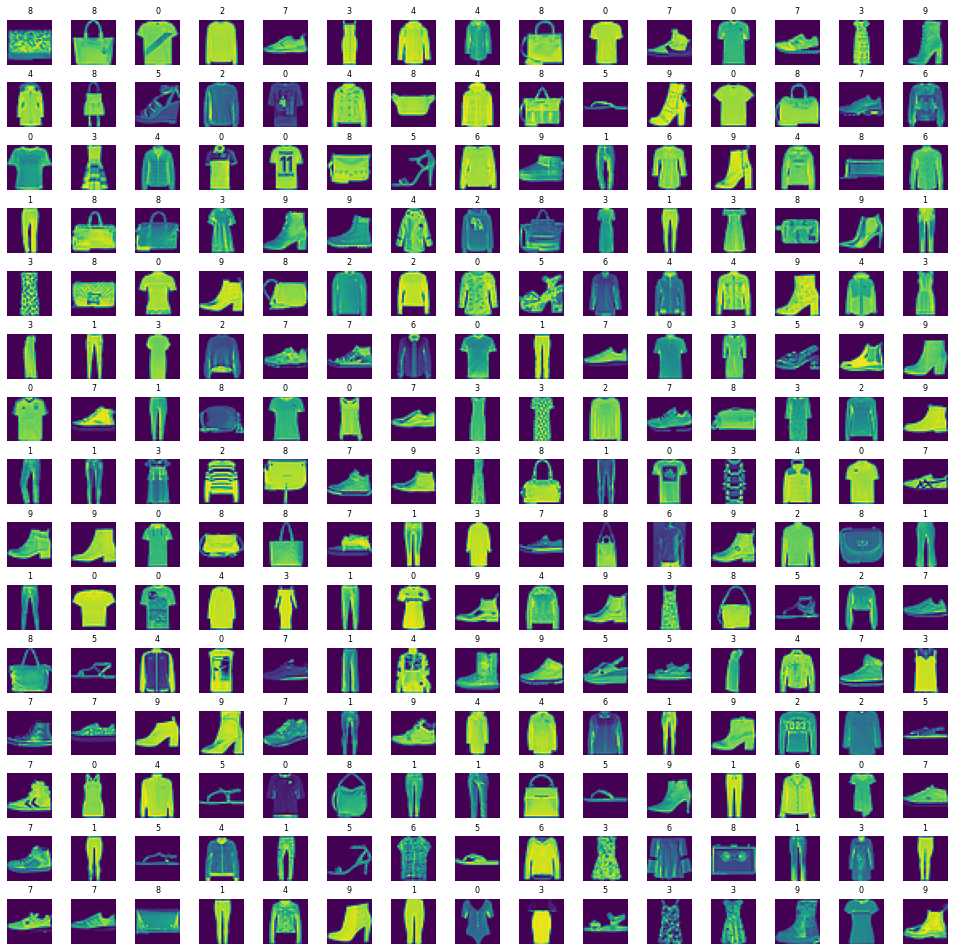

In [4]:
W_grid = 15
L_grid = 15
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() 
n_training = len(X_train) 
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

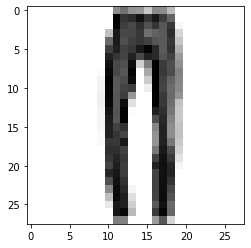

In [5]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
i = random.randint(1,48000)
plt.imshow(X_train[i], cmap="Greys")


### Parte 1 - MLP

In [6]:
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(256, activation='tanh', kernel_initializer = 'he_normal' ,input_shape=(28*28,)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='tanh',kernel_initializer = 'he_normal'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='tanh',kernel_initializer = 'he_normal'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='sigmoid',kernel_initializer = 'he_normal'))
optim = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.975, decay=2e-06, nesterov=True)

model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               12900     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0

La arquitectura del modelo tiene (28x28=784) neuronas de entrada, y 10 de salida.
Modelo basado en: https://github.com/heitorrapela/fashion-mnist-mlp

In [57]:
y_train_trans = tf.keras.utils.to_categorical(y_train, 10)
y_val_trans = tf.keras.utils.to_categorical(y_val, 10)
y_test_trans = tf.keras.utils.to_categorical(y_test, 10)

In [8]:
early_stopping = EarlyStopping(monitor='accuracy', patience=5, verbose=1)
callbacks = [early_stopping]

In [10]:
history = model.fit(X_train, y_train_trans,batch_size=100,epochs=100,validation_data=(X_val, y_val_trans),callbacks=callbacks)


Epoch 1/100
  4/480 [..............................] - ETA: 9s - loss: 2.7312 - accuracy: 0.1025 

c:\users\camlo\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


480/480 [==============================] - 8s 16ms/step - loss: 0.7721 - accuracy: 0.7182 - val_loss: 0.5699 - val_accuracy: 0.7990
Epoch 2/100
480/480 [==============================] - 8s 16ms/step - loss: 0.5639 - accuracy: 0.8028 - val_loss: 0.4686 - val_accuracy: 0.8352
Epoch 3/100
480/480 [==============================] - 8s 16ms/step - loss: 0.5210 - accuracy: 0.8190 - val_loss: 0.4722 - val_accuracy: 0.8354
Epoch 4/100
480/480 [==============================] - 7s 15ms/step - loss: 0.4959 - accuracy: 0.8282 - val_loss: 0.4581 - val_accuracy: 0.8472
Epoch 5/100
480/480 [==============================] - 7s 15ms/step - loss: 0.4761 - accuracy: 0.8336 - val_loss: 0.4392 - val_accuracy: 0.8503
Epoch 6/100
480/480 [==============================] - 7s 15ms/step - loss: 0.4681 - accuracy: 0.8388 - val_loss: 0.4248 - val_accuracy: 0.8526
Epoch 7/100
480/480 [==============================] - 8s 16ms/step - loss: 0.4574 - accuracy: 0.8401 - val_loss: 0.4310 - val_accuracy: 0.8513
Epoc

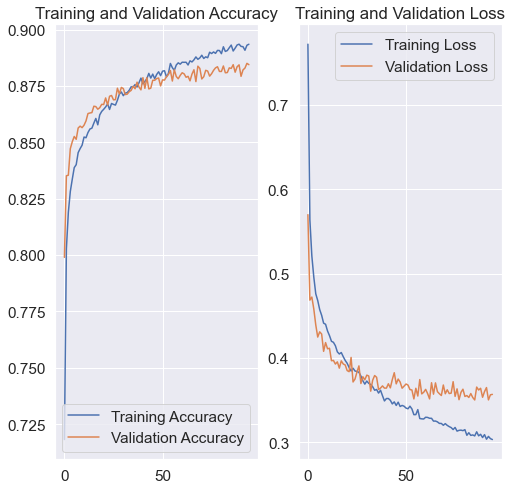

In [13]:
epochs = 95
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


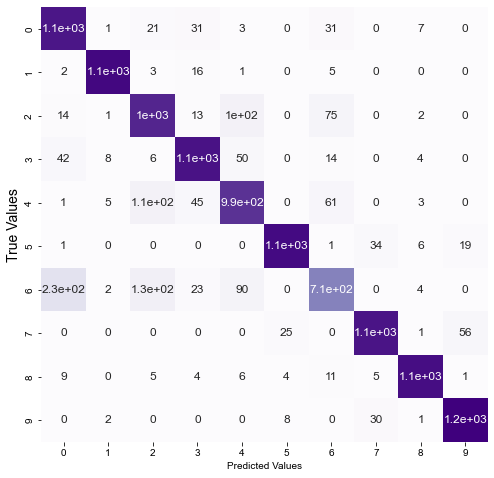

In [11]:
y_pred = model.predict(X_val)
predicted_categories = tf.argmax(y_pred, axis=1)
cm = confusion_matrix(y_val, predicted_categories)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples',xticklabels=[0,1,2,3,4,5,6,7,8,9],yticklabels=[0,1,2,3,4,5,6,7,8,9]);
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=10)
plt.show()

In [14]:
score0 = model.evaluate(X_train, y_train_trans, verbose=0)
score1 = model.evaluate(X_val, y_val_trans, verbose=0)
score2 = model.evaluate(X_test, y_test_trans, verbose=0)
print('Train loss:', score1[0])
print('Train accuracy:', score1[1])
print('Val loss:', score1[0])
print('Val accuracy:', score1[1])
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

c:\users\camlo\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Train loss: 0.3568263351917267
Train accuracy: 0.8844166398048401
Val loss: 0.3568263351917267
Val accuracy: 0.8844166398048401
Test loss: 0.37353289127349854
Test accuracy: 0.8787999749183655


### Parte 2 - Reducción de dimensionalidad y MLP

In [43]:
autoencoder = Sequential()
autoencoder.add(Dense(1000,  activation='relu', input_shape=(784,)))
autoencoder.add(Dense(500,  activation='relu'))
autoencoder.add(Dense(250,  activation='relu'))
autoencoder.add(Dense(32,  activation='relu', name="pre-encoder"))
autoencoder.add(Dense(2,    activation='linear'))
autoencoder.add(Dense(32,  activation='relu'))
autoencoder.add(Dense(250,  activation='relu'))
autoencoder.add(Dense(500,  activation='relu'))
autoencoder.add(Dense(1000,  activation='relu'))
autoencoder.add(Dense(784,  activation='sigmoid'))

autoencoder.compile(loss='mse',optimizer='adam')

Basado en: https://rittikghosh.com/autoencoder.html

In [44]:
autoencoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 1000)              785000    
                                                                 
 dense_49 (Dense)            (None, 500)               500500    
                                                                 
 dense_50 (Dense)            (None, 250)               125250    
                                                                 
 pre-encoder (Dense)         (None, 32)                8032      
                                                                 
 dense_51 (Dense)            (None, 2)                 66        
                                                                 
 dense_52 (Dense)            (None, 32)                96        
                                                                 
 dense_53 (Dense)            (None, 250)              

Se crea una copia de los datos, y se le hace reshape para el autoencoder

In [45]:
scaler=MinMaxScaler()
x_tr = X_train.reshape(X_train.shape[0], 28*28)
x_tr=scaler.fit_transform(x_tr)
x_te = X_test.reshape(X_test.shape[0], 28*28)
x_te=scaler.transform(x_te)
x_v = X_val.reshape(X_val.shape[0], 28*28)
x_v=scaler.transform(x_v)

In [46]:
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
callbacks = [early_stopping]
history2 = autoencoder.fit(x_tr, x_tr, batch_size=128, epochs=25, verbose=1, validation_data=(x_te,x_te),callbacks=callbacks)

Epoch 1/25
  3/375 [..............................] - ETA: 15s - loss: 0.1696

c:\users\camlo\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


375/375 [==============================] - 15s 39ms/step - loss: 0.0428 - val_loss: 0.0308
Epoch 2/25
375/375 [==============================] - 15s 41ms/step - loss: 0.0299 - val_loss: 0.0289
Epoch 3/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0285 - val_loss: 0.0279
Epoch 4/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0277 - val_loss: 0.0272
Epoch 5/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0280 - val_loss: 0.0285
Epoch 6/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0279 - val_loss: 0.0285
Epoch 7/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0277 - val_loss: 0.0272
Epoch 8/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0272 - val_loss: 0.0280
Epoch 9/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0283 - val_loss: 0.0272
Epoch 10/25
375/375 [==============================] - 15s 41ms/step - loss: 0.0265 - val_los

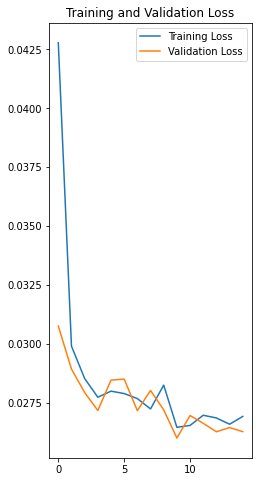

In [47]:
epochs = 15
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [48]:
decoded_tr = autoencoder.predict(x_tr)    
decoded_v= autoencoder.predict(x_v)
decoded_te= autoencoder.predict(x_te)

Imagenes luego de realizar la reducción de dimensionalidad

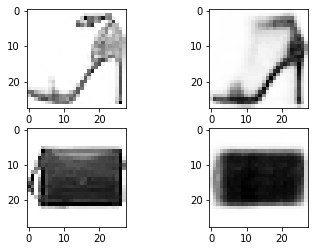

In [49]:
i = random.randint(1,48000)
j = random.randint(1,48000)

fig, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_tr[i].reshape(28,28), cmap='Greys')
axarr[0,1].imshow(decoded_tr[i].reshape(28,28), cmap='Greys')
axarr[1,0].imshow(x_tr[j].reshape(28,28), cmap='Greys')
axarr[1,1].imshow(decoded_tr[j].reshape(28,28), cmap='Greys')

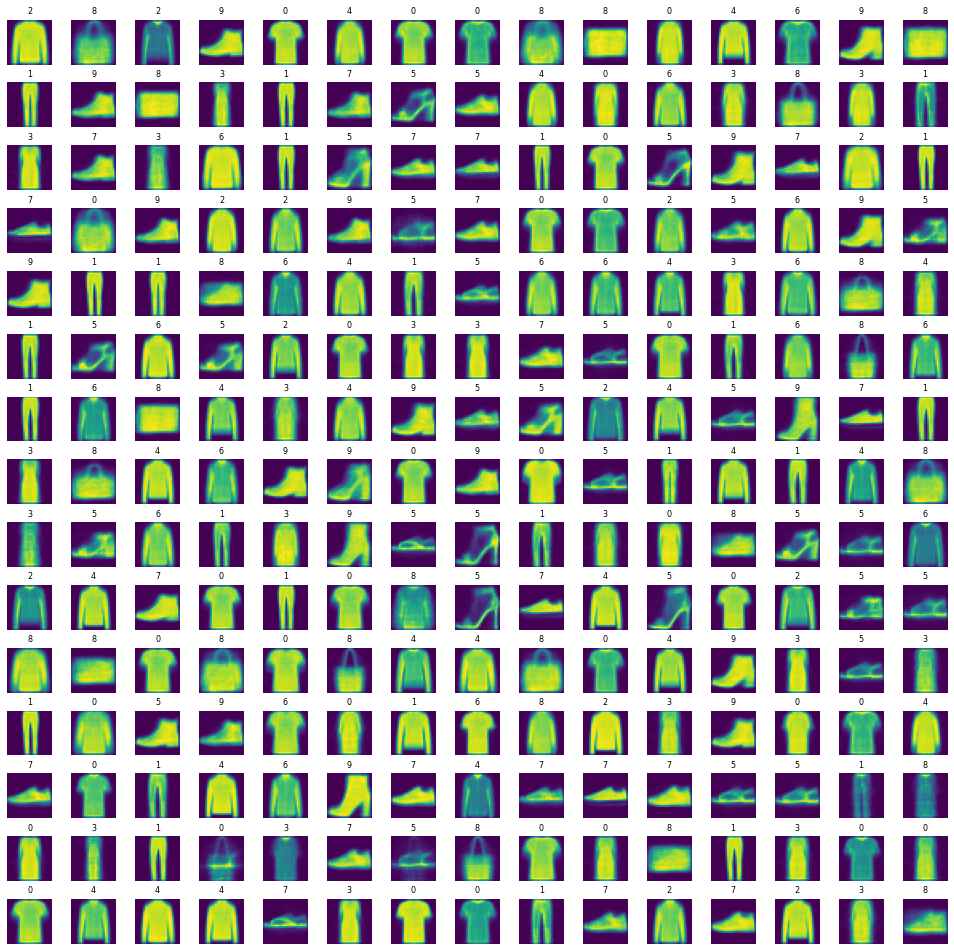

In [50]:
W_grid = 15
L_grid = 15
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() 
n_training = len(decoded_tr) 
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( decoded_tr[index].reshape(28,28) )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Se utiliza el mismo MLP de la parte 1, entrenando con los datos generados por el autoencoder

In [54]:
model2 = Sequential()
model2.add(Flatten(input_shape=(28*28,)))
model2.add(Dense(256, activation='tanh', kernel_initializer = 'he_normal',input_shape=(28*28,)))
model2.add(Dropout(0.4))
model2.add(Dense(128, activation='tanh',kernel_initializer = 'he_normal'))
model2.add(Dropout(0.4))
model2.add(Dense(100, activation='tanh',kernel_initializer = 'he_normal'))
model2.add(Dropout(0.4))
model2.add(Dense(10, activation='sigmoid',kernel_initializer = 'he_normal'))
optim2 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.975, decay=2e-06, nesterov=True)

model2.compile(loss='categorical_crossentropy',optimizer=optim2,metrics=['accuracy'])

print(model2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_65 (Dense)            (None, 256)               200960    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_66 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_67 (Dense)            (None, 100)               12900     
                                                                 
 dropout_8 (Dropout)         (None, 100)              

In [58]:
es = EarlyStopping(monitor='accuracy', patience=5, verbose=1)
cb = [early_stopping]
history3 = model2.fit(decoded_tr, y_train_trans,batch_size=100,epochs=100,validation_data=(decoded_v, y_val_trans),callbacks=cb)

Epoch 1/100
480/480 [==============================] - 8s 16ms/step - loss: 0.9266 - accuracy: 0.6566 - val_loss: 0.7488 - val_accuracy: 0.7216
Epoch 2/100
480/480 [==============================] - 8s 16ms/step - loss: 0.8058 - accuracy: 0.6982 - val_loss: 0.7432 - val_accuracy: 0.7177
Epoch 3/100
480/480 [==============================] - 8s 16ms/step - loss: 0.8031 - accuracy: 0.7004 - val_loss: 0.7364 - val_accuracy: 0.7237
Epoch 4/100
480/480 [==============================] - 8s 16ms/step - loss: 0.7966 - accuracy: 0.7041 - val_loss: 0.7441 - val_accuracy: 0.7262
Epoch 5/100
480/480 [==============================] - 8s 16ms/step - loss: 0.7944 - accuracy: 0.7059 - val_loss: 0.7391 - val_accuracy: 0.7289
Epoch 6/100
480/480 [==============================] - 8s 16ms/step - loss: 0.7941 - accuracy: 0.7056 - val_loss: 0.7384 - val_accuracy: 0.7254
Epoch 7/100
480/480 [==============================] - 8s 17ms/step - loss: 0.7866 - accuracy: 0.7063 - val_loss: 0.7403 - val_accuracy:

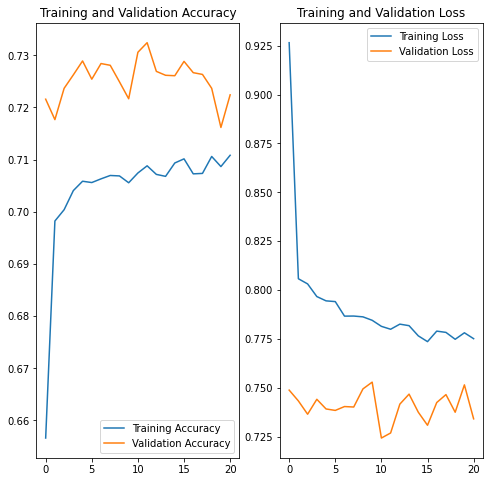

In [59]:
epochs = 21
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

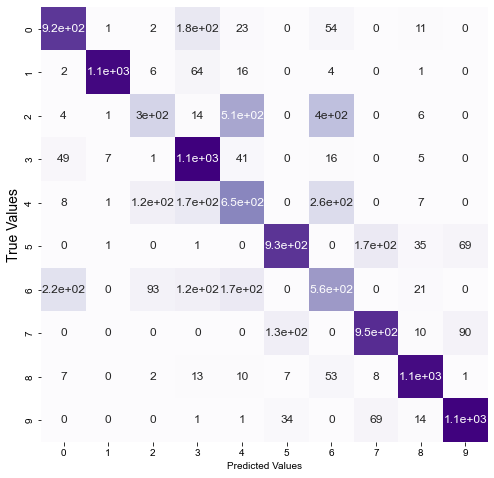

In [60]:
y_pred_enc = model2.predict(decoded_v)
predicted_categories = tf.argmax(y_pred_enc, axis=1)
cm = confusion_matrix(y_val, predicted_categories)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples',xticklabels=[0,1,2,3,4,5,6,7,8,9],yticklabels=[0,1,2,3,4,5,6,7,8,9]);
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=10)
plt.show()

In [61]:
score0 = model2.evaluate(decoded_tr, y_train_trans, verbose=0)
score1 = model2.evaluate(decoded_v, y_val_trans, verbose=0)
score2 = model2.evaluate(decoded_te, y_test_trans, verbose=0)
print('Train loss:', score1[0])
print('Train accuracy:', score1[1])
print('Val loss:', score1[0])
print('Val accuracy:', score1[1])
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

c:\users\camlo\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Train loss: 0.7340479493141174
Train accuracy: 0.7224166393280029
Val loss: 0.7340479493141174
Val accuracy: 0.7224166393280029
Test loss: 0.7429118752479553
Test accuracy: 0.717199981212616


### Parte 3 - Denoising Autoencoder y MLP

In [62]:
def noising_image(data, noise_factor):
    noise_dataset = []
    for img in data:
        noisy_image = img + noise_factor * np.random.randn(*img.shape)
        noisy_image = np.clip(noisy_image, 0., 1.)
        noise_dataset.append(noisy_image)

    noise_dataset = np.array(noise_dataset)
    return noise_dataset

In [64]:
x_tr_noise = noising_image(X_train,0.1)
x_te_noise = noising_image(X_test,0.1)
x_v_noise = noising_image(X_val,0.1)

In [65]:
print(x_tr_noise.shape)
print(x_v_noise.shape)
print(x_te_noise.shape)

(48000, 28, 28)
(12000, 28, 28)
(10000, 28, 28)


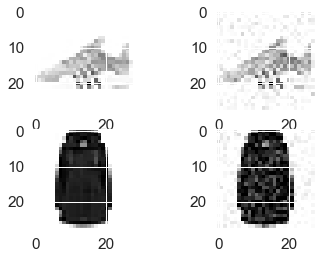

In [67]:
i = random.randint(1,48000)
j = random.randint(1,48000)

fig, axarr = plt.subplots(2,2)
axarr[0,1].imshow(x_tr_noise[i], cmap='Greys')
axarr[0,0].imshow(X_train[i], cmap='Greys')
axarr[1,1].imshow(x_tr_noise[j], cmap='Greys')
axarr[1,0].imshow(X_train[j], cmap='Greys')

Se utiliza la misma arquitectura del autoencoder de la parte b, entrenado con la adición de ruido a las imágenes. 

In [68]:
autoencoder_denoising = Sequential(name="Denoising")
autoencoder_denoising.add(Dense(784,  activation='relu', input_shape=(28*28,)))
autoencoder_denoising.add(Dense(500,  activation='relu'))
autoencoder_denoising.add(Dense(250,  activation='relu'))
autoencoder_denoising.add(Dense(32,  activation='relu', name="pre-encoded"))
autoencoder_denoising.add(Dense(2,    activation='linear'))
autoencoder_denoising.add(Dense(32,  activation='relu'))
autoencoder_denoising.add(Dense(250,  activation='relu'))
autoencoder_denoising.add(Dense(500,  activation='relu'))
autoencoder_denoising.add(Dense(1000,  activation='relu'))
autoencoder_denoising.add(Dense(784,  activation='sigmoid'))
autoencoder_denoising.compile(loss='mse',optimizer='adam')

In [69]:
autoencoder_denoising.summary()


Model: "Denoising"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 784)               615440    
                                                                 
 dense_70 (Dense)            (None, 500)               392500    
                                                                 
 dense_71 (Dense)            (None, 250)               125250    
                                                                 
 pre-encoded (Dense)         (None, 32)                8032      
                                                                 
 dense_72 (Dense)            (None, 2)                 66        
                                                                 
 dense_73 (Dense)            (None, 32)                96        
                                                                 
 dense_74 (Dense)            (None, 250)               82

In [70]:
scaler=MinMaxScaler()
x_tr_noise_r = x_tr_noise.reshape(x_tr_noise.shape[0], 28*28)
x_tr_noise_r=scaler.fit_transform(x_tr_noise_r)
x_te_noise_r = x_te_noise.reshape(x_te_noise.shape[0], 28*28)
x_te_noise_r=scaler.transform(x_te_noise_r)
x_v_noise_r = x_v_noise.reshape(x_v_noise.shape[0], 28*28)
x_v_noise_r=scaler.transform(x_v_noise_r)


In [71]:
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
callbacks = [early_stopping]
history4 = autoencoder.fit(x_tr_noise_r, x_tr_noise_r, batch_size=128, epochs=25, verbose=1, validation_data=(x_te_noise_r,x_te_noise_r),callbacks=callbacks)

Epoch 1/25
  1/375 [..............................] - ETA: 19s - loss: 0.0335

c:\users\camlo\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


375/375 [==============================] - 14s 38ms/step - loss: 0.0299 - val_loss: 0.0294
Epoch 2/25
375/375 [==============================] - 14s 38ms/step - loss: 0.0290 - val_loss: 0.0289
Epoch 3/25
375/375 [==============================] - 14s 39ms/step - loss: 0.0290 - val_loss: 0.0296
Epoch 4/25
375/375 [==============================] - 15s 41ms/step - loss: 0.0292 - val_loss: 0.0292
Epoch 5/25
375/375 [==============================] - 15s 40ms/step - loss: 0.0288 - val_loss: 0.0291
Epoch 6/25
375/375 [==============================] - 14s 39ms/step - loss: 0.0288 - val_loss: 0.0296
Epoch 7/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0298 - val_loss: 0.0293
Epoch 8/25
375/375 [==============================] - 14s 39ms/step - loss: 0.0290 - val_loss: 0.0289
Epoch 9/25
375/375 [==============================] - 14s 39ms/step - loss: 0.0288 - val_loss: 0.0297
Epoch 10/25
375/375 [==============================] - 15s 39ms/step - loss: 0.0294 - val_los

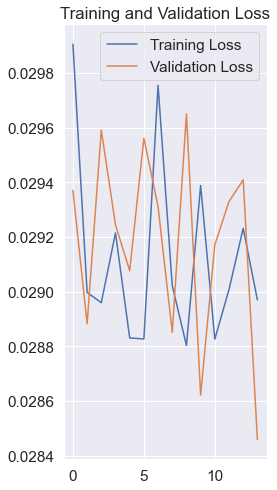

In [73]:
epochs = 14
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [74]:
decoded_noise_tr = autoencoder_denoising.predict(x_tr_noise_r)   
decoded_noise_te = autoencoder_denoising.predict(x_te_noise_r)   
decoded_noise_v = autoencoder_denoising.predict(x_v_noise_r)   


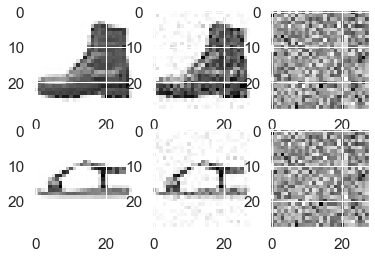

In [75]:
i = random.randint(1,48000)
j = random.randint(1,48000)

fig, axarr = plt.subplots(2,3)
axarr[0,0].imshow(X_train[i], cmap='Greys')
axarr[0,1].imshow(x_tr_noise[i], cmap='Greys')
axarr[0,2].imshow(decoded_noise_tr[i].reshape(28,28), cmap='Greys')
axarr[1,0].imshow(X_train[j], cmap='Greys')
axarr[1,1].imshow(x_tr_noise[j], cmap='Greys')
axarr[1,2].imshow(decoded_noise_tr[j].reshape(28,28), cmap='Greys')

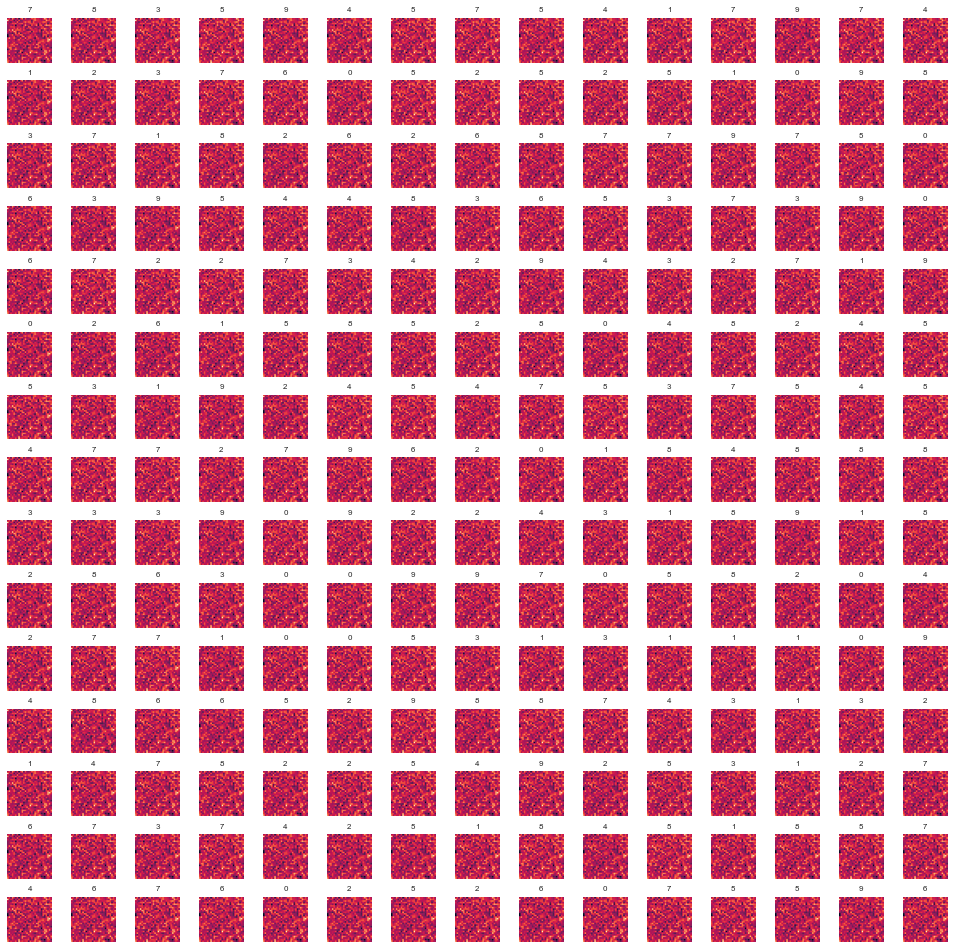

In [77]:
W_grid = 15
L_grid = 15
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() 
n_training = len(decoded_noise_tr) 
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( decoded_noise_tr[index].reshape(28,28) )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [81]:
autoencoder_noise = Sequential(name='AutoencoderNoise')

for layers in autoencoder_denoising.layers:
    print(layers.name)
    layers.trainable = False
    autoencoder_noise.add(layers)
    if layers.name == "pre-encoded":
        break

autoencoder_noise.add(Dense(10, activation='sigmoid',kernel_initializer = 'he_normal'))
optim3 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.975, decay=2e-06, nesterov=True)

autoencoder_noise.compile(loss='categorical_crossentropy',optimizer=optim3,metrics=['accuracy'])

print(autoencoder_noise.summary())

dense_69
dense_70
dense_71
pre-encoded
Model: "AutoencoderNoise"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 784)               615440    
                                                                 
 dense_70 (Dense)            (None, 500)               392500    
                                                                 
 dense_71 (Dense)            (None, 250)               125250    
                                                                 
 pre-encoded (Dense)         (None, 32)                8032      
                                                                 
 dense_79 (Dense)            (None, 10)                330       
                                                                 
Total params: 1,141,552
Trainable params: 330
Non-trainable params: 1,141,222
_________________________________________________________________

División al 10% para entrenamiento y 90% para test.

In [89]:
x_tr_n, x_te_n, y_tr, y_te = train_test_split(decoded_noise_tr, y_train, test_size=0.9, random_state=33)
x_tr_n, x_v_n, y_tr, y_v = train_test_split(x_tr_n, y_tr, test_size=0.2, random_state=33)
print(x_tr_n.size/(28*28))
print(x_te_n.size/(28*28))
print(x_v_n.size/(28*28))

3840.0
43200.0
960.0


In [91]:
y_tr_trans = tf.keras.utils.to_categorical(y_tr, 10)
y_v_trans = tf.keras.utils.to_categorical(y_v, 10)
y_te_trans = tf.keras.utils.to_categorical(y_te, 10)

In [93]:
es = EarlyStopping(monitor='accuracy', patience=5, verbose=1)
cb = [early_stopping]
history5 = autoencoder_noise.fit(x_tr_n, y_tr_trans,batch_size=100,epochs=100,validation_data=(x_v_n, y_v_trans),callbacks=cb)

Epoch 1/100
39/39 [==============================] - 1s 18ms/step - loss: 2.3035 - accuracy: 0.0948 - val_loss: 2.3024 - val_accuracy: 0.1063
Epoch 2/100
39/39 [==============================] - 1s 18ms/step - loss: 2.3030 - accuracy: 0.1031 - val_loss: 2.3015 - val_accuracy: 0.1177
Epoch 3/100
39/39 [==============================] - 1s 17ms/step - loss: 2.3027 - accuracy: 0.1091 - val_loss: 2.3011 - val_accuracy: 0.1177
Epoch 4/100
39/39 [==============================] - 1s 18ms/step - loss: 2.3033 - accuracy: 0.1003 - val_loss: 2.3019 - val_accuracy: 0.1063
Epoch 5/100
39/39 [==============================] - 1s 18ms/step - loss: 2.3024 - accuracy: 0.1081 - val_loss: 2.3008 - val_accuracy: 0.1177
Epoch 6/100
39/39 [==============================] - 1s 19ms/step - loss: 2.3030 - accuracy: 0.1091 - val_loss: 2.3014 - val_accuracy: 0.1177
Epoch 7/100
39/39 [==============================] - 1s 18ms/step - loss: 2.3022 - accuracy: 0.1060 - val_loss: 2.3016 - val_accuracy: 0.1063
Epoch 

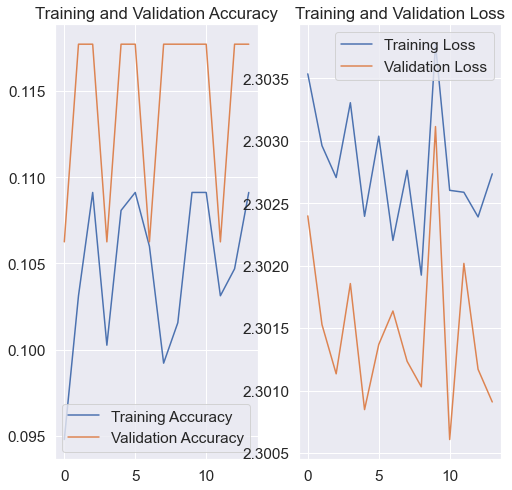

In [94]:
epochs = 14
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

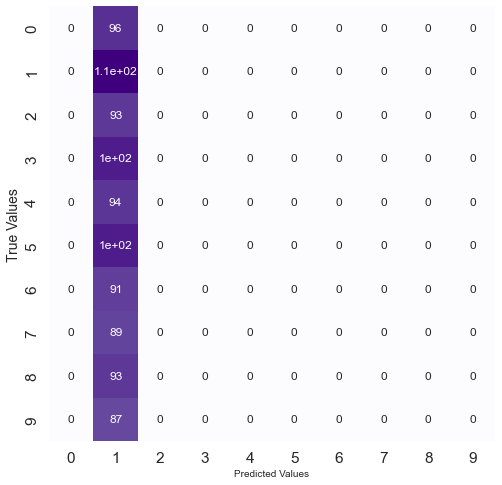

In [95]:
y_pred_noise = autoencoder_noise.predict(x_v_n)
predicted_categories = tf.argmax(y_pred_noise, axis=1)
cm = confusion_matrix(y_v, predicted_categories)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Purples',xticklabels=[0,1,2,3,4,5,6,7,8,9],yticklabels=[0,1,2,3,4,5,6,7,8,9]);
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=10)
plt.show()

# PROBLEMA 2

Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

**Fuente de Datos**: https://www.kaggle.com/mlg-ulb/creditcardfraud


## 2.1 Carga y preparación de datos

In [1]:
import os
os.chdir("/home/ngaitan55/Documents/maestria/primer_semestre/machine_learning_techniques/MLTechniques/Lab4")
transaction_data = pd.read_csv("creditcard.csv")
transaction_data.head()
transaction_data.describe()
transaction_data.shape

In [63]:
transaction_data.dropna(inplace=True)

X, y = transaction_data.loc[:,:'Amount'], transaction_data['Class']
print(np.unique(y, return_counts=True))

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.2, random_state=33)

print(np.unique(y_train, return_counts=True))
X_train

(array([0, 1]), array([284315,    492]))
(array([0, 1]), array([227451,    394]))


Time        V1        V2        V3        V4        V5        V6  \
133959   80589.0 -1.029749 -0.886750  1.525456  0.018604 -0.030239  1.315017   
168762  119374.0 -0.506945  1.515877  0.898573  1.836139  1.660120  0.173390   
221513  142592.0  2.032899 -0.183798 -1.339760 -0.134025  0.332333  0.349340   
183317  125744.0 -1.535875 -0.938860  1.348134  0.093588  0.944312  1.579554   
115149   73765.0 -7.116875  3.220095 -4.938940 -1.127779 -0.866639  3.007076   
...          ...       ...       ...       ...       ...       ...       ...   
76303    56504.0  1.157378  0.013319  0.982792  0.607458 -0.646507 -0.185203   
87713    61803.0  1.069284 -0.079006  1.304495  1.236450 -0.861687  0.148753   
251820  155513.0 -2.972780 -2.403812  1.064995 -0.545382  2.368264  0.417074   
5721      6019.0 -2.414415  0.019077  2.470609  3.467957 -1.032963  1.483254   
261951  160252.0 -0.614953  1.604084 -0.482307  0.552237  1.447826  0.290031   

              V7        V8        V9  ...       V20       V21       V22  \
133959  0.029963  0.457548  0.213728  ...  0.753092  0.052352 -0.093859   
168762  1.390980  0.020182 -1.741904  ... -0.314393 -0.200440 -0.749549   
221513 -0.579505  0.188176  1.044014  ... -0.081864 -0.282935 -0.711988   
183317 -0.320655  0.715160 -1.486529  ...  0.199371 -0.119325 -0.143056   
115149 -1.425167  3.593258  1.272497  ...  1.005250 -0.737171 -1.460917   
...          ...       ...       ...  ...       ...       ...       ...   
76303  -0.414174  0.042867  0.311721  ... -0.042569 -0.004022  0.062903   
87713  -0.567789  0.175798  0.482559  ... -0.017652  0.013422  0.208237   
251820 -0.677048  0.661271  0.285535  ... -0.185828  0.184630  1.138684   
5721    0.296172 -1.801313  1.008500  ... -1.067717  1.234428  0.134437   
261951  0.956167 -0.815285 -0.709389  ...  0.085854  0.862600  0.392959   

             V23       V24       V25       V26       V27       V28  Amount  
133959  0.434683 -1.073242 -0.449460  1.101048  0.025587  0.136574  215.41  
168762 -0.017803  0.381443 -0.325797 -0.616059  0.092138  0.177304    5.92  
221513  0.255920 -0.476301 -0.360309 -0.271169  0.015571 -0.022352    7.32  
183317  0.167991 -1.732740  0.454227 -0.239148  0.328791  0.142486  148.00  
115149 -0.546977  0.969683  0.580949 -0.019334 -0.352561 -0.625335   89.99  
...          ...       ...       ...       ...       ...       ...     ...  
76303   0.084545  0.111306  0.123145  0.276180  0.018452  0.027380   15.88  
87713  -0.047989  0.354829  0.409745 -0.431516  0.071060  0.033825   30.74  
251820  1.511208 -1.615795  0.164760  0.849735  0.419242  0.110403   50.00  
5721    0.721739  0.347498  0.156281  0.381950  0.025110  0.062728  250.80  
261951 -0.224913  0.233789  0.161146 -0.388659  0.575975  0.315374    1.99  

[227845 rows x 30 columns]

## 2.2 Entrenamiento
Entrenamos el modelo base con dos algoritmos: Isolation Forest y OneClass SVM. Para cada modelo hacemos tunning de hiperparámetros y finalmente elegimos el mejor modelo

## 2.2.1 Algoritmo Isolation forest

### Modelo base
Construimos el modelo de isolation forest como base de entrenamiento

In [18]:
cont = sum(y_train == 1)/len(y_train)
print("Contamination ", cont)
iforest = IsolationForest(n_estimators = 500, contamination = cont, verbose = 1)
iforest.fit(X_train)
outlier_decision = iforest.predict(X_train)

Contamination  0.001729245759178389


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s finished


In [19]:
y_pred = [1 if pred == -1 else 0 for pred in outlier_decision]
report_base_IF = classification_report(y_train, y_pred)
print("Test Report para Modelo base IF\n", report_base_IF)
print("Confusion Matrix para Modelo base IF\n", confusion_matrix(y_train, y_pred))


Test Report para Modelo base IF
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.26      0.26      0.26       394

    accuracy                           1.00    227845
   macro avg       0.63      0.63      0.63    227845
weighted avg       1.00      1.00      1.00    227845

Confusion Matrix para Modelo base IF
 [[227159    292]
 [   292    102]]


### Modelo con optimización de hiperparámetros

In [20]:
skf = StratifiedKFold(n_splits=3)
folds = list(skf.split(X_train, y_train))

In [21]:
clf = IsolationForest(random_state=47, verbose = 100, contamination = cont)

y_conv = y_train.astype(np.int8)
y_conv[y_conv==1] = -1
y_conv[y_conv==0] = 1

param_grid = {'n_estimators': [100, 250,  500], 
              'max_samples': list(range(100, 250, 500)),
              'max_features': [5,10,15]
              }

f1sc = make_scorer(f1_score)
grid_search_if = GridSearchCV(clf, 
                            param_grid,
                            scoring=f1sc, 
                            return_train_score=True,
                            cv = folds)
grid_search_if.fit(X_train, y_conv)
print(grid_search_if.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Buil

Building estimator 57 of 100 for this parallel run (total 100)...
Building estimator 58 of 100 for this parallel run (total 100)...
Building estimator 59 of 100 for this parallel run (total 100)...
Building estimator 60 of 100 for this parallel run (total 100)...
Building estimator 61 of 100 for this parallel run (total 100)...
Building estimator 62 of 100 for this parallel run (total 100)...
Building estimator 63 of 100 for this parallel run (total 100)...
Building estimator 64 of 100 for this parallel run (total 100)...
Building estimator 65 of 100 for this parallel run (total 100)...
Building estimator 66 of 100 for this parallel run (total 100)...
Building estimator 67 of 100 for this parallel run (total 100)...
Building estimator 68 of 100 for this parallel run (total 100)...
Building estimator 69 of 100 for this parallel run (total 100)...
Building estimator 70 of 100 for this parallel run (total 100)...
Building estimator 71 of 100 for this parallel run (total 100)...
Building e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 250 for this parallel run (total 250)...
Building estimator 2 of 250 for this parallel run (total 250)...
Building estimator 3 of 250 for this parallel run (total 250)...
Building estimator 4 of 250 for this parallel run (total 250)...
Building estimator 5 of 250 for this parallel run (total 250)...
Building estimator 6 of 250 for this parallel run (total 250)...
Building estimator 7 of 250 for this parallel run (total 250)...
Building estimator 8 of 250 for this parallel run (total 250)...
Building estimator 9 of 250 for this parallel run (total 250)...
Building estimator 10 of 250 for this parallel run (total 250)...
Building estimator 11 of 250 for this parallel run (total 250)...
Building estimator 12 of 250 for this parallel run (total 250)...
Building estimator 13 of 250 for this parallel run (total 250)...
Building estimator 14 of 250 for this parallel run (total 250)...
Buil

Building estimator 178 of 250 for this parallel run (total 250)...
Building estimator 179 of 250 for this parallel run (total 250)...
Building estimator 180 of 250 for this parallel run (total 250)...
Building estimator 181 of 250 for this parallel run (total 250)...
Building estimator 182 of 250 for this parallel run (total 250)...
Building estimator 183 of 250 for this parallel run (total 250)...
Building estimator 184 of 250 for this parallel run (total 250)...
Building estimator 185 of 250 for this parallel run (total 250)...
Building estimator 186 of 250 for this parallel run (total 250)...
Building estimator 187 of 250 for this parallel run (total 250)...
Building estimator 188 of 250 for this parallel run (total 250)...
Building estimator 189 of 250 for this parallel run (total 250)...
Building estimator 190 of 250 for this parallel run (total 250)...
Building estimator 191 of 250 for this parallel run (total 250)...
Building estimator 192 of 250 for this parallel run (total 250

Building estimator 55 of 250 for this parallel run (total 250)...
Building estimator 56 of 250 for this parallel run (total 250)...
Building estimator 57 of 250 for this parallel run (total 250)...
Building estimator 58 of 250 for this parallel run (total 250)...
Building estimator 59 of 250 for this parallel run (total 250)...
Building estimator 60 of 250 for this parallel run (total 250)...
Building estimator 61 of 250 for this parallel run (total 250)...
Building estimator 62 of 250 for this parallel run (total 250)...
Building estimator 63 of 250 for this parallel run (total 250)...
Building estimator 64 of 250 for this parallel run (total 250)...
Building estimator 65 of 250 for this parallel run (total 250)...
Building estimator 66 of 250 for this parallel run (total 250)...
Building estimator 67 of 250 for this parallel run (total 250)...
Building estimator 68 of 250 for this parallel run (total 250)...
Building estimator 69 of 250 for this parallel run (total 250)...
Building e

Building estimator 219 of 250 for this parallel run (total 250)...
Building estimator 220 of 250 for this parallel run (total 250)...
Building estimator 221 of 250 for this parallel run (total 250)...
Building estimator 222 of 250 for this parallel run (total 250)...
Building estimator 223 of 250 for this parallel run (total 250)...
Building estimator 224 of 250 for this parallel run (total 250)...
Building estimator 225 of 250 for this parallel run (total 250)...
Building estimator 226 of 250 for this parallel run (total 250)...
Building estimator 227 of 250 for this parallel run (total 250)...
Building estimator 228 of 250 for this parallel run (total 250)...
Building estimator 229 of 250 for this parallel run (total 250)...
Building estimator 230 of 250 for this parallel run (total 250)...
Building estimator 231 of 250 for this parallel run (total 250)...
Building estimator 232 of 250 for this parallel run (total 250)...
Building estimator 233 of 250 for this parallel run (total 250

Building estimator 119 of 250 for this parallel run (total 250)...
Building estimator 120 of 250 for this parallel run (total 250)...
Building estimator 121 of 250 for this parallel run (total 250)...
Building estimator 122 of 250 for this parallel run (total 250)...
Building estimator 123 of 250 for this parallel run (total 250)...
Building estimator 124 of 250 for this parallel run (total 250)...
Building estimator 125 of 250 for this parallel run (total 250)...
Building estimator 126 of 250 for this parallel run (total 250)...
Building estimator 127 of 250 for this parallel run (total 250)...
Building estimator 128 of 250 for this parallel run (total 250)...
Building estimator 129 of 250 for this parallel run (total 250)...
Building estimator 130 of 250 for this parallel run (total 250)...
Building estimator 131 of 250 for this parallel run (total 250)...
Building estimator 132 of 250 for this parallel run (total 250)...
Building estimator 133 of 250 for this parallel run (total 250

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this parallel run (total 500)...
Building estimator 7 of 500 for this parallel run (total 500)...
Building estimator 8 of 500 for this parallel run (total 500)...
Building estimator 9 of 500 for this parallel run (total 500)...
Building estimator 10 of 500 for this parallel run (total 500)...
Building estimator 11 of 500 for this parallel run (total 500)...
Building estimator 12 of 500 for this parallel run (total 500)...
Building estimator 13 of 500 for this parallel run (total 500)...
Building estimator 14 of 500 for this parallel run (total 500)...
Buil

Building estimator 177 of 500 for this parallel run (total 500)...
Building estimator 178 of 500 for this parallel run (total 500)...
Building estimator 179 of 500 for this parallel run (total 500)...
Building estimator 180 of 500 for this parallel run (total 500)...
Building estimator 181 of 500 for this parallel run (total 500)...
Building estimator 182 of 500 for this parallel run (total 500)...
Building estimator 183 of 500 for this parallel run (total 500)...
Building estimator 184 of 500 for this parallel run (total 500)...
Building estimator 185 of 500 for this parallel run (total 500)...
Building estimator 186 of 500 for this parallel run (total 500)...
Building estimator 187 of 500 for this parallel run (total 500)...
Building estimator 188 of 500 for this parallel run (total 500)...
Building estimator 189 of 500 for this parallel run (total 500)...
Building estimator 190 of 500 for this parallel run (total 500)...
Building estimator 191 of 500 for this parallel run (total 500

Building estimator 354 of 500 for this parallel run (total 500)...
Building estimator 355 of 500 for this parallel run (total 500)...
Building estimator 356 of 500 for this parallel run (total 500)...
Building estimator 357 of 500 for this parallel run (total 500)...
Building estimator 358 of 500 for this parallel run (total 500)...
Building estimator 359 of 500 for this parallel run (total 500)...
Building estimator 360 of 500 for this parallel run (total 500)...
Building estimator 361 of 500 for this parallel run (total 500)...
Building estimator 362 of 500 for this parallel run (total 500)...
Building estimator 363 of 500 for this parallel run (total 500)...
Building estimator 364 of 500 for this parallel run (total 500)...
Building estimator 365 of 500 for this parallel run (total 500)...
Building estimator 366 of 500 for this parallel run (total 500)...
Building estimator 367 of 500 for this parallel run (total 500)...
Building estimator 368 of 500 for this parallel run (total 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this parallel run (total 500)...
Building estimator 7 of 500 for this parallel run (total 500)...
Building estimator 8 of 500 for this parallel run (total 500)...
Building estimator 9 of 500 for this parallel run (total 500)...
Building estimator 10 of 500 for this parallel run (total 500)...
Building estimator 11 of 500 for this parallel run (total 500)...
Building estimator 12 of 500 for this parallel run (total 500)...
Building estimator 13 of 500 for this parallel run (total 500)...
Building estimator 14 of 500 for this parallel run (total 500)...
Buil

Building estimator 159 of 500 for this parallel run (total 500)...
Building estimator 160 of 500 for this parallel run (total 500)...
Building estimator 161 of 500 for this parallel run (total 500)...
Building estimator 162 of 500 for this parallel run (total 500)...
Building estimator 163 of 500 for this parallel run (total 500)...
Building estimator 164 of 500 for this parallel run (total 500)...
Building estimator 165 of 500 for this parallel run (total 500)...
Building estimator 166 of 500 for this parallel run (total 500)...
Building estimator 167 of 500 for this parallel run (total 500)...
Building estimator 168 of 500 for this parallel run (total 500)...
Building estimator 169 of 500 for this parallel run (total 500)...
Building estimator 170 of 500 for this parallel run (total 500)...
Building estimator 171 of 500 for this parallel run (total 500)...
Building estimator 172 of 500 for this parallel run (total 500)...
Building estimator 173 of 500 for this parallel run (total 500

Building estimator 316 of 500 for this parallel run (total 500)...
Building estimator 317 of 500 for this parallel run (total 500)...
Building estimator 318 of 500 for this parallel run (total 500)...
Building estimator 319 of 500 for this parallel run (total 500)...
Building estimator 320 of 500 for this parallel run (total 500)...
Building estimator 321 of 500 for this parallel run (total 500)...
Building estimator 322 of 500 for this parallel run (total 500)...
Building estimator 323 of 500 for this parallel run (total 500)...
Building estimator 324 of 500 for this parallel run (total 500)...
Building estimator 325 of 500 for this parallel run (total 500)...
Building estimator 326 of 500 for this parallel run (total 500)...
Building estimator 327 of 500 for this parallel run (total 500)...
Building estimator 328 of 500 for this parallel run (total 500)...
Building estimator 329 of 500 for this parallel run (total 500)...
Building estimator 330 of 500 for this parallel run (total 500

Building estimator 481 of 500 for this parallel run (total 500)...
Building estimator 482 of 500 for this parallel run (total 500)...
Building estimator 483 of 500 for this parallel run (total 500)...
Building estimator 484 of 500 for this parallel run (total 500)...
Building estimator 485 of 500 for this parallel run (total 500)...
Building estimator 486 of 500 for this parallel run (total 500)...
Building estimator 487 of 500 for this parallel run (total 500)...
Building estimator 488 of 500 for this parallel run (total 500)...
Building estimator 489 of 500 for this parallel run (total 500)...
Building estimator 490 of 500 for this parallel run (total 500)...
Building estimator 491 of 500 for this parallel run (total 500)...
Building estimator 492 of 500 for this parallel run (total 500)...
Building estimator 493 of 500 for this parallel run (total 500)...
Building estimator 494 of 500 for this parallel run (total 500)...
Building estimator 495 of 500 for this parallel run (total 500

Building estimator 116 of 500 for this parallel run (total 500)...
Building estimator 117 of 500 for this parallel run (total 500)...
Building estimator 118 of 500 for this parallel run (total 500)...
Building estimator 119 of 500 for this parallel run (total 500)...
Building estimator 120 of 500 for this parallel run (total 500)...
Building estimator 121 of 500 for this parallel run (total 500)...
Building estimator 122 of 500 for this parallel run (total 500)...
Building estimator 123 of 500 for this parallel run (total 500)...
Building estimator 124 of 500 for this parallel run (total 500)...
Building estimator 125 of 500 for this parallel run (total 500)...
Building estimator 126 of 500 for this parallel run (total 500)...
Building estimator 127 of 500 for this parallel run (total 500)...
Building estimator 128 of 500 for this parallel run (total 500)...
Building estimator 129 of 500 for this parallel run (total 500)...
Building estimator 130 of 500 for this parallel run (total 500

Building estimator 267 of 500 for this parallel run (total 500)...
Building estimator 268 of 500 for this parallel run (total 500)...
Building estimator 269 of 500 for this parallel run (total 500)...
Building estimator 270 of 500 for this parallel run (total 500)...
Building estimator 271 of 500 for this parallel run (total 500)...
Building estimator 272 of 500 for this parallel run (total 500)...
Building estimator 273 of 500 for this parallel run (total 500)...
Building estimator 274 of 500 for this parallel run (total 500)...
Building estimator 275 of 500 for this parallel run (total 500)...
Building estimator 276 of 500 for this parallel run (total 500)...
Building estimator 277 of 500 for this parallel run (total 500)...
Building estimator 278 of 500 for this parallel run (total 500)...
Building estimator 279 of 500 for this parallel run (total 500)...
Building estimator 280 of 500 for this parallel run (total 500)...
Building estimator 281 of 500 for this parallel run (total 500

Building estimator 437 of 500 for this parallel run (total 500)...
Building estimator 438 of 500 for this parallel run (total 500)...
Building estimator 439 of 500 for this parallel run (total 500)...
Building estimator 440 of 500 for this parallel run (total 500)...
Building estimator 441 of 500 for this parallel run (total 500)...
Building estimator 442 of 500 for this parallel run (total 500)...
Building estimator 443 of 500 for this parallel run (total 500)...
Building estimator 444 of 500 for this parallel run (total 500)...
Building estimator 445 of 500 for this parallel run (total 500)...
Building estimator 446 of 500 for this parallel run (total 500)...
Building estimator 447 of 500 for this parallel run (total 500)...
Building estimator 448 of 500 for this parallel run (total 500)...
Building estimator 449 of 500 for this parallel run (total 500)...
Building estimator 450 of 500 for this parallel run (total 500)...
Building estimator 451 of 500 for this parallel run (total 500

Building estimator 81 of 100 for this parallel run (total 100)...
Building estimator 82 of 100 for this parallel run (total 100)...
Building estimator 83 of 100 for this parallel run (total 100)...
Building estimator 84 of 100 for this parallel run (total 100)...
Building estimator 85 of 100 for this parallel run (total 100)...
Building estimator 86 of 100 for this parallel run (total 100)...
Building estimator 87 of 100 for this parallel run (total 100)...
Building estimator 88 of 100 for this parallel run (total 100)...
Building estimator 89 of 100 for this parallel run (total 100)...
Building estimator 90 of 100 for this parallel run (total 100)...
Building estimator 91 of 100 for this parallel run (total 100)...
Building estimator 92 of 100 for this parallel run (total 100)...
Building estimator 93 of 100 for this parallel run (total 100)...
Building estimator 94 of 100 for this parallel run (total 100)...
Building estimator 95 of 100 for this parallel run (total 100)...
Building e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Buil

Building estimator 39 of 250 for this parallel run (total 250)...
Building estimator 40 of 250 for this parallel run (total 250)...
Building estimator 41 of 250 for this parallel run (total 250)...
Building estimator 42 of 250 for this parallel run (total 250)...
Building estimator 43 of 250 for this parallel run (total 250)...
Building estimator 44 of 250 for this parallel run (total 250)...
Building estimator 45 of 250 for this parallel run (total 250)...
Building estimator 46 of 250 for this parallel run (total 250)...
Building estimator 47 of 250 for this parallel run (total 250)...
Building estimator 48 of 250 for this parallel run (total 250)...
Building estimator 49 of 250 for this parallel run (total 250)...
Building estimator 50 of 250 for this parallel run (total 250)...
Building estimator 51 of 250 for this parallel run (total 250)...
Building estimator 52 of 250 for this parallel run (total 250)...
Building estimator 53 of 250 for this parallel run (total 250)...
Building e

Building estimator 198 of 250 for this parallel run (total 250)...
Building estimator 199 of 250 for this parallel run (total 250)...
Building estimator 200 of 250 for this parallel run (total 250)...
Building estimator 201 of 250 for this parallel run (total 250)...
Building estimator 202 of 250 for this parallel run (total 250)...
Building estimator 203 of 250 for this parallel run (total 250)...
Building estimator 204 of 250 for this parallel run (total 250)...
Building estimator 205 of 250 for this parallel run (total 250)...
Building estimator 206 of 250 for this parallel run (total 250)...
Building estimator 207 of 250 for this parallel run (total 250)...
Building estimator 208 of 250 for this parallel run (total 250)...
Building estimator 209 of 250 for this parallel run (total 250)...
Building estimator 210 of 250 for this parallel run (total 250)...
Building estimator 211 of 250 for this parallel run (total 250)...
Building estimator 212 of 250 for this parallel run (total 250

Building estimator 79 of 250 for this parallel run (total 250)...
Building estimator 80 of 250 for this parallel run (total 250)...
Building estimator 81 of 250 for this parallel run (total 250)...
Building estimator 82 of 250 for this parallel run (total 250)...
Building estimator 83 of 250 for this parallel run (total 250)...
Building estimator 84 of 250 for this parallel run (total 250)...
Building estimator 85 of 250 for this parallel run (total 250)...
Building estimator 86 of 250 for this parallel run (total 250)...
Building estimator 87 of 250 for this parallel run (total 250)...
Building estimator 88 of 250 for this parallel run (total 250)...
Building estimator 89 of 250 for this parallel run (total 250)...
Building estimator 90 of 250 for this parallel run (total 250)...
Building estimator 91 of 250 for this parallel run (total 250)...
Building estimator 92 of 250 for this parallel run (total 250)...
Building estimator 93 of 250 for this parallel run (total 250)...
Building e

Building estimator 235 of 250 for this parallel run (total 250)...
Building estimator 236 of 250 for this parallel run (total 250)...
Building estimator 237 of 250 for this parallel run (total 250)...
Building estimator 238 of 250 for this parallel run (total 250)...
Building estimator 239 of 250 for this parallel run (total 250)...
Building estimator 240 of 250 for this parallel run (total 250)...
Building estimator 241 of 250 for this parallel run (total 250)...
Building estimator 242 of 250 for this parallel run (total 250)...
Building estimator 243 of 250 for this parallel run (total 250)...
Building estimator 244 of 250 for this parallel run (total 250)...
Building estimator 245 of 250 for this parallel run (total 250)...
Building estimator 246 of 250 for this parallel run (total 250)...
Building estimator 247 of 250 for this parallel run (total 250)...
Building estimator 248 of 250 for this parallel run (total 250)...
Building estimator 249 of 250 for this parallel run (total 250

Building estimator 119 of 250 for this parallel run (total 250)...
Building estimator 120 of 250 for this parallel run (total 250)...
Building estimator 121 of 250 for this parallel run (total 250)...
Building estimator 122 of 250 for this parallel run (total 250)...
Building estimator 123 of 250 for this parallel run (total 250)...
Building estimator 124 of 250 for this parallel run (total 250)...
Building estimator 125 of 250 for this parallel run (total 250)...
Building estimator 126 of 250 for this parallel run (total 250)...
Building estimator 127 of 250 for this parallel run (total 250)...
Building estimator 128 of 250 for this parallel run (total 250)...
Building estimator 129 of 250 for this parallel run (total 250)...
Building estimator 130 of 250 for this parallel run (total 250)...
Building estimator 131 of 250 for this parallel run (total 250)...
Building estimator 132 of 250 for this parallel run (total 250)...
Building estimator 133 of 250 for this parallel run (total 250

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this parallel run (total 500)...
Building estimator 7 of 500 for this parallel run (total 500)...
Building estimator 8 of 500 for this parallel run (total 500)...
Building estimator 9 of 500 for this parallel run (total 500)...
Building estimator 10 of 500 for this parallel run (total 500)...
Building estimator 11 of 500 for this parallel run (total 500)...
Building estimator 12 of 500 for this parallel run (total 500)...
Building estimator 13 of 500 for this parallel run (total 500)...
Building estimator 14 of 500 for this parallel run (total 500)...
Buil

Building estimator 162 of 500 for this parallel run (total 500)...
Building estimator 163 of 500 for this parallel run (total 500)...
Building estimator 164 of 500 for this parallel run (total 500)...
Building estimator 165 of 500 for this parallel run (total 500)...
Building estimator 166 of 500 for this parallel run (total 500)...
Building estimator 167 of 500 for this parallel run (total 500)...
Building estimator 168 of 500 for this parallel run (total 500)...
Building estimator 169 of 500 for this parallel run (total 500)...
Building estimator 170 of 500 for this parallel run (total 500)...
Building estimator 171 of 500 for this parallel run (total 500)...
Building estimator 172 of 500 for this parallel run (total 500)...
Building estimator 173 of 500 for this parallel run (total 500)...
Building estimator 174 of 500 for this parallel run (total 500)...
Building estimator 175 of 500 for this parallel run (total 500)...
Building estimator 176 of 500 for this parallel run (total 500

Building estimator 321 of 500 for this parallel run (total 500)...
Building estimator 322 of 500 for this parallel run (total 500)...
Building estimator 323 of 500 for this parallel run (total 500)...
Building estimator 324 of 500 for this parallel run (total 500)...
Building estimator 325 of 500 for this parallel run (total 500)...
Building estimator 326 of 500 for this parallel run (total 500)...
Building estimator 327 of 500 for this parallel run (total 500)...
Building estimator 328 of 500 for this parallel run (total 500)...
Building estimator 329 of 500 for this parallel run (total 500)...
Building estimator 330 of 500 for this parallel run (total 500)...
Building estimator 331 of 500 for this parallel run (total 500)...
Building estimator 332 of 500 for this parallel run (total 500)...
Building estimator 333 of 500 for this parallel run (total 500)...
Building estimator 334 of 500 for this parallel run (total 500)...
Building estimator 335 of 500 for this parallel run (total 500

Building estimator 481 of 500 for this parallel run (total 500)...
Building estimator 482 of 500 for this parallel run (total 500)...
Building estimator 483 of 500 for this parallel run (total 500)...
Building estimator 484 of 500 for this parallel run (total 500)...
Building estimator 485 of 500 for this parallel run (total 500)...
Building estimator 486 of 500 for this parallel run (total 500)...
Building estimator 487 of 500 for this parallel run (total 500)...
Building estimator 488 of 500 for this parallel run (total 500)...
Building estimator 489 of 500 for this parallel run (total 500)...
Building estimator 490 of 500 for this parallel run (total 500)...
Building estimator 491 of 500 for this parallel run (total 500)...
Building estimator 492 of 500 for this parallel run (total 500)...
Building estimator 493 of 500 for this parallel run (total 500)...
Building estimator 494 of 500 for this parallel run (total 500)...
Building estimator 495 of 500 for this parallel run (total 500

Building estimator 121 of 500 for this parallel run (total 500)...
Building estimator 122 of 500 for this parallel run (total 500)...
Building estimator 123 of 500 for this parallel run (total 500)...
Building estimator 124 of 500 for this parallel run (total 500)...
Building estimator 125 of 500 for this parallel run (total 500)...
Building estimator 126 of 500 for this parallel run (total 500)...
Building estimator 127 of 500 for this parallel run (total 500)...
Building estimator 128 of 500 for this parallel run (total 500)...
Building estimator 129 of 500 for this parallel run (total 500)...
Building estimator 130 of 500 for this parallel run (total 500)...
Building estimator 131 of 500 for this parallel run (total 500)...
Building estimator 132 of 500 for this parallel run (total 500)...
Building estimator 133 of 500 for this parallel run (total 500)...
Building estimator 134 of 500 for this parallel run (total 500)...
Building estimator 135 of 500 for this parallel run (total 500

Building estimator 278 of 500 for this parallel run (total 500)...
Building estimator 279 of 500 for this parallel run (total 500)...
Building estimator 280 of 500 for this parallel run (total 500)...
Building estimator 281 of 500 for this parallel run (total 500)...
Building estimator 282 of 500 for this parallel run (total 500)...
Building estimator 283 of 500 for this parallel run (total 500)...
Building estimator 284 of 500 for this parallel run (total 500)...
Building estimator 285 of 500 for this parallel run (total 500)...
Building estimator 286 of 500 for this parallel run (total 500)...
Building estimator 287 of 500 for this parallel run (total 500)...
Building estimator 288 of 500 for this parallel run (total 500)...
Building estimator 289 of 500 for this parallel run (total 500)...
Building estimator 290 of 500 for this parallel run (total 500)...
Building estimator 291 of 500 for this parallel run (total 500)...
Building estimator 292 of 500 for this parallel run (total 500

Building estimator 438 of 500 for this parallel run (total 500)...
Building estimator 439 of 500 for this parallel run (total 500)...
Building estimator 440 of 500 for this parallel run (total 500)...
Building estimator 441 of 500 for this parallel run (total 500)...
Building estimator 442 of 500 for this parallel run (total 500)...
Building estimator 443 of 500 for this parallel run (total 500)...
Building estimator 444 of 500 for this parallel run (total 500)...
Building estimator 445 of 500 for this parallel run (total 500)...
Building estimator 446 of 500 for this parallel run (total 500)...
Building estimator 447 of 500 for this parallel run (total 500)...
Building estimator 448 of 500 for this parallel run (total 500)...
Building estimator 449 of 500 for this parallel run (total 500)...
Building estimator 450 of 500 for this parallel run (total 500)...
Building estimator 451 of 500 for this parallel run (total 500)...
Building estimator 452 of 500 for this parallel run (total 500

Building estimator 74 of 500 for this parallel run (total 500)...
Building estimator 75 of 500 for this parallel run (total 500)...
Building estimator 76 of 500 for this parallel run (total 500)...
Building estimator 77 of 500 for this parallel run (total 500)...
Building estimator 78 of 500 for this parallel run (total 500)...
Building estimator 79 of 500 for this parallel run (total 500)...
Building estimator 80 of 500 for this parallel run (total 500)...
Building estimator 81 of 500 for this parallel run (total 500)...
Building estimator 82 of 500 for this parallel run (total 500)...
Building estimator 83 of 500 for this parallel run (total 500)...
Building estimator 84 of 500 for this parallel run (total 500)...
Building estimator 85 of 500 for this parallel run (total 500)...
Building estimator 86 of 500 for this parallel run (total 500)...
Building estimator 87 of 500 for this parallel run (total 500)...
Building estimator 88 of 500 for this parallel run (total 500)...
Building e

Building estimator 231 of 500 for this parallel run (total 500)...
Building estimator 232 of 500 for this parallel run (total 500)...
Building estimator 233 of 500 for this parallel run (total 500)...
Building estimator 234 of 500 for this parallel run (total 500)...
Building estimator 235 of 500 for this parallel run (total 500)...
Building estimator 236 of 500 for this parallel run (total 500)...
Building estimator 237 of 500 for this parallel run (total 500)...
Building estimator 238 of 500 for this parallel run (total 500)...
Building estimator 239 of 500 for this parallel run (total 500)...
Building estimator 240 of 500 for this parallel run (total 500)...
Building estimator 241 of 500 for this parallel run (total 500)...
Building estimator 242 of 500 for this parallel run (total 500)...
Building estimator 243 of 500 for this parallel run (total 500)...
Building estimator 244 of 500 for this parallel run (total 500)...
Building estimator 245 of 500 for this parallel run (total 500

Building estimator 385 of 500 for this parallel run (total 500)...
Building estimator 386 of 500 for this parallel run (total 500)...
Building estimator 387 of 500 for this parallel run (total 500)...
Building estimator 388 of 500 for this parallel run (total 500)...
Building estimator 389 of 500 for this parallel run (total 500)...
Building estimator 390 of 500 for this parallel run (total 500)...
Building estimator 391 of 500 for this parallel run (total 500)...
Building estimator 392 of 500 for this parallel run (total 500)...
Building estimator 393 of 500 for this parallel run (total 500)...
Building estimator 394 of 500 for this parallel run (total 500)...
Building estimator 395 of 500 for this parallel run (total 500)...
Building estimator 396 of 500 for this parallel run (total 500)...
Building estimator 397 of 500 for this parallel run (total 500)...
Building estimator 398 of 500 for this parallel run (total 500)...
Building estimator 399 of 500 for this parallel run (total 500

Building estimator 31 of 100 for this parallel run (total 100)...
Building estimator 32 of 100 for this parallel run (total 100)...
Building estimator 33 of 100 for this parallel run (total 100)...
Building estimator 34 of 100 for this parallel run (total 100)...
Building estimator 35 of 100 for this parallel run (total 100)...
Building estimator 36 of 100 for this parallel run (total 100)...
Building estimator 37 of 100 for this parallel run (total 100)...
Building estimator 38 of 100 for this parallel run (total 100)...
Building estimator 39 of 100 for this parallel run (total 100)...
Building estimator 40 of 100 for this parallel run (total 100)...
Building estimator 41 of 100 for this parallel run (total 100)...
Building estimator 42 of 100 for this parallel run (total 100)...
Building estimator 43 of 100 for this parallel run (total 100)...
Building estimator 44 of 100 for this parallel run (total 100)...
Building estimator 45 of 100 for this parallel run (total 100)...
Building e

Building estimator 62 of 100 for this parallel run (total 100)...
Building estimator 63 of 100 for this parallel run (total 100)...
Building estimator 64 of 100 for this parallel run (total 100)...
Building estimator 65 of 100 for this parallel run (total 100)...
Building estimator 66 of 100 for this parallel run (total 100)...
Building estimator 67 of 100 for this parallel run (total 100)...
Building estimator 68 of 100 for this parallel run (total 100)...
Building estimator 69 of 100 for this parallel run (total 100)...
Building estimator 70 of 100 for this parallel run (total 100)...
Building estimator 71 of 100 for this parallel run (total 100)...
Building estimator 72 of 100 for this parallel run (total 100)...
Building estimator 73 of 100 for this parallel run (total 100)...
Building estimator 74 of 100 for this parallel run (total 100)...
Building estimator 75 of 100 for this parallel run (total 100)...
Building estimator 76 of 100 for this parallel run (total 100)...
Building e

Building estimator 92 of 100 for this parallel run (total 100)...
Building estimator 93 of 100 for this parallel run (total 100)...
Building estimator 94 of 100 for this parallel run (total 100)...
Building estimator 95 of 100 for this parallel run (total 100)...
Building estimator 96 of 100 for this parallel run (total 100)...
Building estimator 97 of 100 for this parallel run (total 100)...
Building estimator 98 of 100 for this parallel run (total 100)...
Building estimator 99 of 100 for this parallel run (total 100)...
Building estimator 100 of 100 for this parallel run (total 100)...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 250 for this parallel run (total 250)...
Building estimator 2 of 250 for this parallel run (total 250)...
Building estimator 3 of 250 for this paralle

Building estimator 119 of 250 for this parallel run (total 250)...
Building estimator 120 of 250 for this parallel run (total 250)...
Building estimator 121 of 250 for this parallel run (total 250)...
Building estimator 122 of 250 for this parallel run (total 250)...
Building estimator 123 of 250 for this parallel run (total 250)...
Building estimator 124 of 250 for this parallel run (total 250)...
Building estimator 125 of 250 for this parallel run (total 250)...
Building estimator 126 of 250 for this parallel run (total 250)...
Building estimator 127 of 250 for this parallel run (total 250)...
Building estimator 128 of 250 for this parallel run (total 250)...
Building estimator 129 of 250 for this parallel run (total 250)...
Building estimator 130 of 250 for this parallel run (total 250)...
Building estimator 131 of 250 for this parallel run (total 250)...
Building estimator 132 of 250 for this parallel run (total 250)...
Building estimator 133 of 250 for this parallel run (total 250

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 250 for this parallel run (total 250)...
Building estimator 2 of 250 for this parallel run (total 250)...
Building estimator 3 of 250 for this parallel run (total 250)...
Building estimator 4 of 250 for this parallel run (total 250)...
Building estimator 5 of 250 for this parallel run (total 250)...
Building estimator 6 of 250 for this parallel run (total 250)...
Building estimator 7 of 250 for this parallel run (total 250)...
Building estimator 8 of 250 for this parallel run (total 250)...
Building estimator 9 of 250 for this parallel run (total 250)...
Building estimator 10 of 250 for this parallel run (total 250)...
Building estimator 11 of 250 for this parallel run (total 250)...
Building estimator 12 of 250 for this parallel run (total 250)...
Building estimator 13 of 250 for this parallel run (total 250)...
Building estimator 14 of 250 for this parallel run (total 250)...
Buil

Building estimator 152 of 250 for this parallel run (total 250)...
Building estimator 153 of 250 for this parallel run (total 250)...
Building estimator 154 of 250 for this parallel run (total 250)...
Building estimator 155 of 250 for this parallel run (total 250)...
Building estimator 156 of 250 for this parallel run (total 250)...
Building estimator 157 of 250 for this parallel run (total 250)...
Building estimator 158 of 250 for this parallel run (total 250)...
Building estimator 159 of 250 for this parallel run (total 250)...
Building estimator 160 of 250 for this parallel run (total 250)...
Building estimator 161 of 250 for this parallel run (total 250)...
Building estimator 162 of 250 for this parallel run (total 250)...
Building estimator 163 of 250 for this parallel run (total 250)...
Building estimator 164 of 250 for this parallel run (total 250)...
Building estimator 165 of 250 for this parallel run (total 250)...
Building estimator 166 of 250 for this parallel run (total 250

Building estimator 31 of 250 for this parallel run (total 250)...
Building estimator 32 of 250 for this parallel run (total 250)...
Building estimator 33 of 250 for this parallel run (total 250)...
Building estimator 34 of 250 for this parallel run (total 250)...
Building estimator 35 of 250 for this parallel run (total 250)...
Building estimator 36 of 250 for this parallel run (total 250)...
Building estimator 37 of 250 for this parallel run (total 250)...
Building estimator 38 of 250 for this parallel run (total 250)...
Building estimator 39 of 250 for this parallel run (total 250)...
Building estimator 40 of 250 for this parallel run (total 250)...
Building estimator 41 of 250 for this parallel run (total 250)...
Building estimator 42 of 250 for this parallel run (total 250)...
Building estimator 43 of 250 for this parallel run (total 250)...
Building estimator 44 of 250 for this parallel run (total 250)...
Building estimator 45 of 250 for this parallel run (total 250)...
Building e

Building estimator 178 of 250 for this parallel run (total 250)...
Building estimator 179 of 250 for this parallel run (total 250)...
Building estimator 180 of 250 for this parallel run (total 250)...
Building estimator 181 of 250 for this parallel run (total 250)...
Building estimator 182 of 250 for this parallel run (total 250)...
Building estimator 183 of 250 for this parallel run (total 250)...
Building estimator 184 of 250 for this parallel run (total 250)...
Building estimator 185 of 250 for this parallel run (total 250)...
Building estimator 186 of 250 for this parallel run (total 250)...
Building estimator 187 of 250 for this parallel run (total 250)...
Building estimator 188 of 250 for this parallel run (total 250)...
Building estimator 189 of 250 for this parallel run (total 250)...
Building estimator 190 of 250 for this parallel run (total 250)...
Building estimator 191 of 250 for this parallel run (total 250)...
Building estimator 192 of 250 for this parallel run (total 250

Building estimator 62 of 500 for this parallel run (total 500)...
Building estimator 63 of 500 for this parallel run (total 500)...
Building estimator 64 of 500 for this parallel run (total 500)...
Building estimator 65 of 500 for this parallel run (total 500)...
Building estimator 66 of 500 for this parallel run (total 500)...
Building estimator 67 of 500 for this parallel run (total 500)...
Building estimator 68 of 500 for this parallel run (total 500)...
Building estimator 69 of 500 for this parallel run (total 500)...
Building estimator 70 of 500 for this parallel run (total 500)...
Building estimator 71 of 500 for this parallel run (total 500)...
Building estimator 72 of 500 for this parallel run (total 500)...
Building estimator 73 of 500 for this parallel run (total 500)...
Building estimator 74 of 500 for this parallel run (total 500)...
Building estimator 75 of 500 for this parallel run (total 500)...
Building estimator 76 of 500 for this parallel run (total 500)...
Building e

Building estimator 213 of 500 for this parallel run (total 500)...
Building estimator 214 of 500 for this parallel run (total 500)...
Building estimator 215 of 500 for this parallel run (total 500)...
Building estimator 216 of 500 for this parallel run (total 500)...
Building estimator 217 of 500 for this parallel run (total 500)...
Building estimator 218 of 500 for this parallel run (total 500)...
Building estimator 219 of 500 for this parallel run (total 500)...
Building estimator 220 of 500 for this parallel run (total 500)...
Building estimator 221 of 500 for this parallel run (total 500)...
Building estimator 222 of 500 for this parallel run (total 500)...
Building estimator 223 of 500 for this parallel run (total 500)...
Building estimator 224 of 500 for this parallel run (total 500)...
Building estimator 225 of 500 for this parallel run (total 500)...
Building estimator 226 of 500 for this parallel run (total 500)...
Building estimator 227 of 500 for this parallel run (total 500

Building estimator 363 of 500 for this parallel run (total 500)...
Building estimator 364 of 500 for this parallel run (total 500)...
Building estimator 365 of 500 for this parallel run (total 500)...
Building estimator 366 of 500 for this parallel run (total 500)...
Building estimator 367 of 500 for this parallel run (total 500)...
Building estimator 368 of 500 for this parallel run (total 500)...
Building estimator 369 of 500 for this parallel run (total 500)...
Building estimator 370 of 500 for this parallel run (total 500)...
Building estimator 371 of 500 for this parallel run (total 500)...
Building estimator 372 of 500 for this parallel run (total 500)...
Building estimator 373 of 500 for this parallel run (total 500)...
Building estimator 374 of 500 for this parallel run (total 500)...
Building estimator 375 of 500 for this parallel run (total 500)...
Building estimator 376 of 500 for this parallel run (total 500)...
Building estimator 377 of 500 for this parallel run (total 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this parallel run (total 500)...
Building estimator 7 of 500 for this parallel run (total 500)...
Building estimator 8 of 500 for this parallel run (total 500)...
Building estimator 9 of 500 for this parallel run (total 500)...
Building estimator 10 of 500 for this parallel run (total 500)...
Building estimator 11 of 500 for this parallel run (total 500)...
Building estimator 12 of 500 for this parallel run (total 500)...
Building estimator 13 of 500 for this parallel run (total 500)...
Building estimator 14 of 500 for this parallel run (total 500)...
Buil

Building estimator 152 of 500 for this parallel run (total 500)...
Building estimator 153 of 500 for this parallel run (total 500)...
Building estimator 154 of 500 for this parallel run (total 500)...
Building estimator 155 of 500 for this parallel run (total 500)...
Building estimator 156 of 500 for this parallel run (total 500)...
Building estimator 157 of 500 for this parallel run (total 500)...
Building estimator 158 of 500 for this parallel run (total 500)...
Building estimator 159 of 500 for this parallel run (total 500)...
Building estimator 160 of 500 for this parallel run (total 500)...
Building estimator 161 of 500 for this parallel run (total 500)...
Building estimator 162 of 500 for this parallel run (total 500)...
Building estimator 163 of 500 for this parallel run (total 500)...
Building estimator 164 of 500 for this parallel run (total 500)...
Building estimator 165 of 500 for this parallel run (total 500)...
Building estimator 166 of 500 for this parallel run (total 500

Building estimator 302 of 500 for this parallel run (total 500)...
Building estimator 303 of 500 for this parallel run (total 500)...
Building estimator 304 of 500 for this parallel run (total 500)...
Building estimator 305 of 500 for this parallel run (total 500)...
Building estimator 306 of 500 for this parallel run (total 500)...
Building estimator 307 of 500 for this parallel run (total 500)...
Building estimator 308 of 500 for this parallel run (total 500)...
Building estimator 309 of 500 for this parallel run (total 500)...
Building estimator 310 of 500 for this parallel run (total 500)...
Building estimator 311 of 500 for this parallel run (total 500)...
Building estimator 312 of 500 for this parallel run (total 500)...
Building estimator 313 of 500 for this parallel run (total 500)...
Building estimator 314 of 500 for this parallel run (total 500)...
Building estimator 315 of 500 for this parallel run (total 500)...
Building estimator 316 of 500 for this parallel run (total 500

Building estimator 425 of 500 for this parallel run (total 500)...
Building estimator 426 of 500 for this parallel run (total 500)...
Building estimator 427 of 500 for this parallel run (total 500)...
Building estimator 428 of 500 for this parallel run (total 500)...
Building estimator 429 of 500 for this parallel run (total 500)...
Building estimator 430 of 500 for this parallel run (total 500)...
Building estimator 431 of 500 for this parallel run (total 500)...
Building estimator 432 of 500 for this parallel run (total 500)...
Building estimator 433 of 500 for this parallel run (total 500)...
Building estimator 434 of 500 for this parallel run (total 500)...
Building estimator 435 of 500 for this parallel run (total 500)...
Building estimator 436 of 500 for this parallel run (total 500)...
Building estimator 437 of 500 for this parallel run (total 500)...
Building estimator 438 of 500 for this parallel run (total 500)...
Building estimator 439 of 500 for this parallel run (total 500

Building estimator 61 of 500 for this parallel run (total 500)...
Building estimator 62 of 500 for this parallel run (total 500)...
Building estimator 63 of 500 for this parallel run (total 500)...
Building estimator 64 of 500 for this parallel run (total 500)...
Building estimator 65 of 500 for this parallel run (total 500)...
Building estimator 66 of 500 for this parallel run (total 500)...
Building estimator 67 of 500 for this parallel run (total 500)...
Building estimator 68 of 500 for this parallel run (total 500)...
Building estimator 69 of 500 for this parallel run (total 500)...
Building estimator 70 of 500 for this parallel run (total 500)...
Building estimator 71 of 500 for this parallel run (total 500)...
Building estimator 72 of 500 for this parallel run (total 500)...
Building estimator 73 of 500 for this parallel run (total 500)...
Building estimator 74 of 500 for this parallel run (total 500)...
Building estimator 75 of 500 for this parallel run (total 500)...
Building e

Building estimator 206 of 500 for this parallel run (total 500)...
Building estimator 207 of 500 for this parallel run (total 500)...
Building estimator 208 of 500 for this parallel run (total 500)...
Building estimator 209 of 500 for this parallel run (total 500)...
Building estimator 210 of 500 for this parallel run (total 500)...
Building estimator 211 of 500 for this parallel run (total 500)...
Building estimator 212 of 500 for this parallel run (total 500)...
Building estimator 213 of 500 for this parallel run (total 500)...
Building estimator 214 of 500 for this parallel run (total 500)...
Building estimator 215 of 500 for this parallel run (total 500)...
Building estimator 216 of 500 for this parallel run (total 500)...
Building estimator 217 of 500 for this parallel run (total 500)...
Building estimator 218 of 500 for this parallel run (total 500)...
Building estimator 219 of 500 for this parallel run (total 500)...
Building estimator 220 of 500 for this parallel run (total 500

Building estimator 354 of 500 for this parallel run (total 500)...
Building estimator 355 of 500 for this parallel run (total 500)...
Building estimator 356 of 500 for this parallel run (total 500)...
Building estimator 357 of 500 for this parallel run (total 500)...
Building estimator 358 of 500 for this parallel run (total 500)...
Building estimator 359 of 500 for this parallel run (total 500)...
Building estimator 360 of 500 for this parallel run (total 500)...
Building estimator 361 of 500 for this parallel run (total 500)...
Building estimator 362 of 500 for this parallel run (total 500)...
Building estimator 363 of 500 for this parallel run (total 500)...
Building estimator 364 of 500 for this parallel run (total 500)...
Building estimator 365 of 500 for this parallel run (total 500)...
Building estimator 366 of 500 for this parallel run (total 500)...
Building estimator 367 of 500 for this parallel run (total 500)...
Building estimator 368 of 500 for this parallel run (total 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Buil

In [26]:
best_model_if = grid_search_if.best_estimator_
outlier_pred_if_best_model = best_model_if.predict(X_train)
Y_pred_if_best_model = [1 if pred == -1 else 0 for pred in outlier_pred_if_best_model]
report_best_IF = classification_report(y_train, Y_pred_if_best_model)
print("Test Report para mejor modelo IF\n", report_best_IF)
print("Confusion Matrix para mejor modelo IF\n", confusion_matrix(y_train, Y_pred_if_best_model))

Test Report para mejor modelo IF
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.34      0.34      0.34       394

    accuracy                           1.00    227845
   macro avg       0.67      0.67      0.67    227845
weighted avg       1.00      1.00      1.00    227845

Confusion Matrix para mejor modelo IF
 [[227192    259]
 [   259    135]]


### Modelo con remuestreo de la clase minoritaria y isolation forest

In [64]:
for_sampling = X_train.copy()
for_sampling.loc[:,'Class'] = y_train 
majority = for_sampling[for_sampling.Class==0]
minority = for_sampling[for_sampling.Class==1]
minority_upsampled = resample(minority, 
                                 replace=True,     
                                 n_samples=len(majority),   
                                 random_state=123)
upsampled = pd.concat([majority, minority_upsampled])
print(upsampled.Class.value_counts())
X_train_upsampled, y_train_upsampled = upsampled.loc[:,:'Amount'], upsampled['Class']
print(np.unique(y_train_upsampled, return_counts=True))


0    227451
1    227451
Name: Class, dtype: int64
(array([0, 1]), array([227451, 227451]))


In [35]:
cont_ups = sum(y_train_upsampled == 1)/len(y_train_upsampled)
print("Contamination ", cont_ups)
iforest_ups = IsolationForest(n_estimators = 500, contamination = cont_ups, verbose = 1)
iforest_ups.fit(X_train_upsampled)
outlier_decision_ups = iforest.predict(X_train_upsampled)

y_pred_ups = [1 if pred == -1 else 0 for pred in outlier_decision_ups]
report_base_IF_ups = classification_report(y_train_upsampled, y_pred_ups)
print("Test Report para Modelo base IF\n", report_base_IF_ups)
print("Confusion Matrix para Modelo base IF\n", confusion_matrix(y_train_upsampled, y_pred_ups))

Contamination  0.5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s finished


Test Report para Modelo base IF
               precision    recall  f1-score   support

           0       0.57      1.00      0.73    227451
           1       1.00      0.26      0.41    227451

    accuracy                           0.63    454902
   macro avg       0.78      0.63      0.57    454902
weighted avg       0.78      0.63      0.57    454902

Confusion Matrix para Modelo base IF
 [[227159    292]
 [168918  58533]]


In [36]:
skf = StratifiedKFold(n_splits=3)
folds = list(skf.split(X_train_upsampled, y_train_upsampled))

clf = IsolationForest(random_state=47, verbose = 100, contamination = cont_ups)

y_conv_ups = y_train_upsampled.astype(np.int8)
y_conv_ups[y_conv_ups==1] = -1
y_conv_ups[y_conv_ups==0] = 1

param_grid = {'n_estimators': [100, 250,  500], 
              'max_samples': list(range(100, 250, 500)),
              'max_features': [5,10,15]
              }

f1sc = make_scorer(f1_score)
grid_search_if = GridSearchCV(clf, 
                            param_grid,
                            scoring=f1sc, 
                            return_train_score=True,
                            cv = folds)
grid_search_if.fit(X_train_upsampled, y_conv_ups)
print(grid_search_if.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 100 for this parallel run (total 100)...
Building estimator 2 of 100 for this parallel run (total 100)...
Building estimator 3 of 100 for this parallel run (total 100)...
Building estimator 4 of 100 for this parallel run (total 100)...
Building estimator 5 of 100 for this parallel run (total 100)...
Building estimator 6 of 100 for this parallel run (total 100)...
Building estimator 7 of 100 for this parallel run (total 100)...
Building estimator 8 of 100 for this parallel run (total 100)...
Building estimator 9 of 100 for this parallel run (total 100)...
Building estimator 10 of 100 for this parallel run (total 100)...
Building estimator 11 of 100 for this parallel run (total 100)...
Building estimator 12 of 100 for this parallel run (total 100)...
Building estimator 13 of 100 for this parallel run (total 100)...
Building estimator 14 of 100 for this parallel run (total 100)...
Buil

Building estimator 36 of 100 for this parallel run (total 100)...
Building estimator 37 of 100 for this parallel run (total 100)...
Building estimator 38 of 100 for this parallel run (total 100)...
Building estimator 39 of 100 for this parallel run (total 100)...
Building estimator 40 of 100 for this parallel run (total 100)...
Building estimator 41 of 100 for this parallel run (total 100)...
Building estimator 42 of 100 for this parallel run (total 100)...
Building estimator 43 of 100 for this parallel run (total 100)...
Building estimator 44 of 100 for this parallel run (total 100)...
Building estimator 45 of 100 for this parallel run (total 100)...
Building estimator 46 of 100 for this parallel run (total 100)...
Building estimator 47 of 100 for this parallel run (total 100)...
Building estimator 48 of 100 for this parallel run (total 100)...
Building estimator 49 of 100 for this parallel run (total 100)...
Building estimator 50 of 100 for this parallel run (total 100)...
Building e

Building estimator 70 of 100 for this parallel run (total 100)...
Building estimator 71 of 100 for this parallel run (total 100)...
Building estimator 72 of 100 for this parallel run (total 100)...
Building estimator 73 of 100 for this parallel run (total 100)...
Building estimator 74 of 100 for this parallel run (total 100)...
Building estimator 75 of 100 for this parallel run (total 100)...
Building estimator 76 of 100 for this parallel run (total 100)...
Building estimator 77 of 100 for this parallel run (total 100)...
Building estimator 78 of 100 for this parallel run (total 100)...
Building estimator 79 of 100 for this parallel run (total 100)...
Building estimator 80 of 100 for this parallel run (total 100)...
Building estimator 81 of 100 for this parallel run (total 100)...
Building estimator 82 of 100 for this parallel run (total 100)...
Building estimator 83 of 100 for this parallel run (total 100)...
Building estimator 84 of 100 for this parallel run (total 100)...
Building e

Building estimator 97 of 250 for this parallel run (total 250)...
Building estimator 98 of 250 for this parallel run (total 250)...
Building estimator 99 of 250 for this parallel run (total 250)...
Building estimator 100 of 250 for this parallel run (total 250)...
Building estimator 101 of 250 for this parallel run (total 250)...
Building estimator 102 of 250 for this parallel run (total 250)...
Building estimator 103 of 250 for this parallel run (total 250)...
Building estimator 104 of 250 for this parallel run (total 250)...
Building estimator 105 of 250 for this parallel run (total 250)...
Building estimator 106 of 250 for this parallel run (total 250)...
Building estimator 107 of 250 for this parallel run (total 250)...
Building estimator 108 of 250 for this parallel run (total 250)...
Building estimator 109 of 250 for this parallel run (total 250)...
Building estimator 110 of 250 for this parallel run (total 250)...
Building estimator 111 of 250 for this parallel run (total 250)..

Building estimator 233 of 250 for this parallel run (total 250)...
Building estimator 234 of 250 for this parallel run (total 250)...
Building estimator 235 of 250 for this parallel run (total 250)...
Building estimator 236 of 250 for this parallel run (total 250)...
Building estimator 237 of 250 for this parallel run (total 250)...
Building estimator 238 of 250 for this parallel run (total 250)...
Building estimator 239 of 250 for this parallel run (total 250)...
Building estimator 240 of 250 for this parallel run (total 250)...
Building estimator 241 of 250 for this parallel run (total 250)...
Building estimator 242 of 250 for this parallel run (total 250)...
Building estimator 243 of 250 for this parallel run (total 250)...
Building estimator 244 of 250 for this parallel run (total 250)...
Building estimator 245 of 250 for this parallel run (total 250)...
Building estimator 246 of 250 for this parallel run (total 250)...
Building estimator 247 of 250 for this parallel run (total 250

Building estimator 108 of 250 for this parallel run (total 250)...
Building estimator 109 of 250 for this parallel run (total 250)...
Building estimator 110 of 250 for this parallel run (total 250)...
Building estimator 111 of 250 for this parallel run (total 250)...
Building estimator 112 of 250 for this parallel run (total 250)...
Building estimator 113 of 250 for this parallel run (total 250)...
Building estimator 114 of 250 for this parallel run (total 250)...
Building estimator 115 of 250 for this parallel run (total 250)...
Building estimator 116 of 250 for this parallel run (total 250)...
Building estimator 117 of 250 for this parallel run (total 250)...
Building estimator 118 of 250 for this parallel run (total 250)...
Building estimator 119 of 250 for this parallel run (total 250)...
Building estimator 120 of 250 for this parallel run (total 250)...
Building estimator 121 of 250 for this parallel run (total 250)...
Building estimator 122 of 250 for this parallel run (total 250

Building estimator 240 of 250 for this parallel run (total 250)...
Building estimator 241 of 250 for this parallel run (total 250)...
Building estimator 242 of 250 for this parallel run (total 250)...
Building estimator 243 of 250 for this parallel run (total 250)...
Building estimator 244 of 250 for this parallel run (total 250)...
Building estimator 245 of 250 for this parallel run (total 250)...
Building estimator 246 of 250 for this parallel run (total 250)...
Building estimator 247 of 250 for this parallel run (total 250)...
Building estimator 248 of 250 for this parallel run (total 250)...
Building estimator 249 of 250 for this parallel run (total 250)...
Building estimator 250 of 250 for this parallel run (total 250)...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 250 for 

Building estimator 111 of 250 for this parallel run (total 250)...
Building estimator 112 of 250 for this parallel run (total 250)...
Building estimator 113 of 250 for this parallel run (total 250)...
Building estimator 114 of 250 for this parallel run (total 250)...
Building estimator 115 of 250 for this parallel run (total 250)...
Building estimator 116 of 250 for this parallel run (total 250)...
Building estimator 117 of 250 for this parallel run (total 250)...
Building estimator 118 of 250 for this parallel run (total 250)...
Building estimator 119 of 250 for this parallel run (total 250)...
Building estimator 120 of 250 for this parallel run (total 250)...
Building estimator 121 of 250 for this parallel run (total 250)...
Building estimator 122 of 250 for this parallel run (total 250)...
Building estimator 123 of 250 for this parallel run (total 250)...
Building estimator 124 of 250 for this parallel run (total 250)...
Building estimator 125 of 250 for this parallel run (total 250

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this parallel run (total 500)...
Building estimator 7 of 500 for this parallel run (total 500)...
Building estimator 8 of 500 for this parallel run (total 500)...
Building estimator 9 of 500 for this parallel run (total 500)...
Building estimator 10 of 500 for this parallel run (total 500)...
Building estimator 11 of 500 for this parallel run (total 500)...
Building estimator 12 of 500 for this parallel run (total 500)...
Building estimator 13 of 500 for this parallel run (total 500)...
Building estimator 14 of 500 for this parallel run (total 500)...
Buil

Building estimator 147 of 500 for this parallel run (total 500)...
Building estimator 148 of 500 for this parallel run (total 500)...
Building estimator 149 of 500 for this parallel run (total 500)...
Building estimator 150 of 500 for this parallel run (total 500)...
Building estimator 151 of 500 for this parallel run (total 500)...
Building estimator 152 of 500 for this parallel run (total 500)...
Building estimator 153 of 500 for this parallel run (total 500)...
Building estimator 154 of 500 for this parallel run (total 500)...
Building estimator 155 of 500 for this parallel run (total 500)...
Building estimator 156 of 500 for this parallel run (total 500)...
Building estimator 157 of 500 for this parallel run (total 500)...
Building estimator 158 of 500 for this parallel run (total 500)...
Building estimator 159 of 500 for this parallel run (total 500)...
Building estimator 160 of 500 for this parallel run (total 500)...
Building estimator 161 of 500 for this parallel run (total 500

Building estimator 295 of 500 for this parallel run (total 500)...
Building estimator 296 of 500 for this parallel run (total 500)...
Building estimator 297 of 500 for this parallel run (total 500)...
Building estimator 298 of 500 for this parallel run (total 500)...
Building estimator 299 of 500 for this parallel run (total 500)...
Building estimator 300 of 500 for this parallel run (total 500)...
Building estimator 301 of 500 for this parallel run (total 500)...
Building estimator 302 of 500 for this parallel run (total 500)...
Building estimator 303 of 500 for this parallel run (total 500)...
Building estimator 304 of 500 for this parallel run (total 500)...
Building estimator 305 of 500 for this parallel run (total 500)...
Building estimator 306 of 500 for this parallel run (total 500)...
Building estimator 307 of 500 for this parallel run (total 500)...
Building estimator 308 of 500 for this parallel run (total 500)...
Building estimator 309 of 500 for this parallel run (total 500

Building estimator 443 of 500 for this parallel run (total 500)...
Building estimator 444 of 500 for this parallel run (total 500)...
Building estimator 445 of 500 for this parallel run (total 500)...
Building estimator 446 of 500 for this parallel run (total 500)...
Building estimator 447 of 500 for this parallel run (total 500)...
Building estimator 448 of 500 for this parallel run (total 500)...
Building estimator 449 of 500 for this parallel run (total 500)...
Building estimator 450 of 500 for this parallel run (total 500)...
Building estimator 451 of 500 for this parallel run (total 500)...
Building estimator 452 of 500 for this parallel run (total 500)...
Building estimator 453 of 500 for this parallel run (total 500)...
Building estimator 454 of 500 for this parallel run (total 500)...
Building estimator 455 of 500 for this parallel run (total 500)...
Building estimator 456 of 500 for this parallel run (total 500)...
Building estimator 457 of 500 for this parallel run (total 500

Building estimator 71 of 500 for this parallel run (total 500)...
Building estimator 72 of 500 for this parallel run (total 500)...
Building estimator 73 of 500 for this parallel run (total 500)...
Building estimator 74 of 500 for this parallel run (total 500)...
Building estimator 75 of 500 for this parallel run (total 500)...
Building estimator 76 of 500 for this parallel run (total 500)...
Building estimator 77 of 500 for this parallel run (total 500)...
Building estimator 78 of 500 for this parallel run (total 500)...
Building estimator 79 of 500 for this parallel run (total 500)...
Building estimator 80 of 500 for this parallel run (total 500)...
Building estimator 81 of 500 for this parallel run (total 500)...
Building estimator 82 of 500 for this parallel run (total 500)...
Building estimator 83 of 500 for this parallel run (total 500)...
Building estimator 84 of 500 for this parallel run (total 500)...
Building estimator 85 of 500 for this parallel run (total 500)...
Building e

Building estimator 212 of 500 for this parallel run (total 500)...
Building estimator 213 of 500 for this parallel run (total 500)...
Building estimator 214 of 500 for this parallel run (total 500)...
Building estimator 215 of 500 for this parallel run (total 500)...
Building estimator 216 of 500 for this parallel run (total 500)...
Building estimator 217 of 500 for this parallel run (total 500)...
Building estimator 218 of 500 for this parallel run (total 500)...
Building estimator 219 of 500 for this parallel run (total 500)...
Building estimator 220 of 500 for this parallel run (total 500)...
Building estimator 221 of 500 for this parallel run (total 500)...
Building estimator 222 of 500 for this parallel run (total 500)...
Building estimator 223 of 500 for this parallel run (total 500)...
Building estimator 224 of 500 for this parallel run (total 500)...
Building estimator 225 of 500 for this parallel run (total 500)...
Building estimator 226 of 500 for this parallel run (total 500

Building estimator 352 of 500 for this parallel run (total 500)...
Building estimator 353 of 500 for this parallel run (total 500)...
Building estimator 354 of 500 for this parallel run (total 500)...
Building estimator 355 of 500 for this parallel run (total 500)...
Building estimator 356 of 500 for this parallel run (total 500)...
Building estimator 357 of 500 for this parallel run (total 500)...
Building estimator 358 of 500 for this parallel run (total 500)...
Building estimator 359 of 500 for this parallel run (total 500)...
Building estimator 360 of 500 for this parallel run (total 500)...
Building estimator 361 of 500 for this parallel run (total 500)...
Building estimator 362 of 500 for this parallel run (total 500)...
Building estimator 363 of 500 for this parallel run (total 500)...
Building estimator 364 of 500 for this parallel run (total 500)...
Building estimator 365 of 500 for this parallel run (total 500)...
Building estimator 366 of 500 for this parallel run (total 500

Building estimator 495 of 500 for this parallel run (total 500)...
Building estimator 496 of 500 for this parallel run (total 500)...
Building estimator 497 of 500 for this parallel run (total 500)...
Building estimator 498 of 500 for this parallel run (total 500)...
Building estimator 499 of 500 for this parallel run (total 500)...
Building estimator 500 of 500 for this parallel run (total 500)...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this paral

Building estimator 141 of 500 for this parallel run (total 500)...
Building estimator 142 of 500 for this parallel run (total 500)...
Building estimator 143 of 500 for this parallel run (total 500)...
Building estimator 144 of 500 for this parallel run (total 500)...
Building estimator 145 of 500 for this parallel run (total 500)...
Building estimator 146 of 500 for this parallel run (total 500)...
Building estimator 147 of 500 for this parallel run (total 500)...
Building estimator 148 of 500 for this parallel run (total 500)...
Building estimator 149 of 500 for this parallel run (total 500)...
Building estimator 150 of 500 for this parallel run (total 500)...
Building estimator 151 of 500 for this parallel run (total 500)...
Building estimator 152 of 500 for this parallel run (total 500)...
Building estimator 153 of 500 for this parallel run (total 500)...
Building estimator 154 of 500 for this parallel run (total 500)...
Building estimator 155 of 500 for this parallel run (total 500

Building estimator 282 of 500 for this parallel run (total 500)...
Building estimator 283 of 500 for this parallel run (total 500)...
Building estimator 284 of 500 for this parallel run (total 500)...
Building estimator 285 of 500 for this parallel run (total 500)...
Building estimator 286 of 500 for this parallel run (total 500)...
Building estimator 287 of 500 for this parallel run (total 500)...
Building estimator 288 of 500 for this parallel run (total 500)...
Building estimator 289 of 500 for this parallel run (total 500)...
Building estimator 290 of 500 for this parallel run (total 500)...
Building estimator 291 of 500 for this parallel run (total 500)...
Building estimator 292 of 500 for this parallel run (total 500)...
Building estimator 293 of 500 for this parallel run (total 500)...
Building estimator 294 of 500 for this parallel run (total 500)...
Building estimator 295 of 500 for this parallel run (total 500)...
Building estimator 296 of 500 for this parallel run (total 500

Building estimator 421 of 500 for this parallel run (total 500)...
Building estimator 422 of 500 for this parallel run (total 500)...
Building estimator 423 of 500 for this parallel run (total 500)...
Building estimator 424 of 500 for this parallel run (total 500)...
Building estimator 425 of 500 for this parallel run (total 500)...
Building estimator 426 of 500 for this parallel run (total 500)...
Building estimator 427 of 500 for this parallel run (total 500)...
Building estimator 428 of 500 for this parallel run (total 500)...
Building estimator 429 of 500 for this parallel run (total 500)...
Building estimator 430 of 500 for this parallel run (total 500)...
Building estimator 431 of 500 for this parallel run (total 500)...
Building estimator 432 of 500 for this parallel run (total 500)...
Building estimator 433 of 500 for this parallel run (total 500)...
Building estimator 434 of 500 for this parallel run (total 500)...
Building estimator 435 of 500 for this parallel run (total 500

Building estimator 44 of 100 for this parallel run (total 100)...
Building estimator 45 of 100 for this parallel run (total 100)...
Building estimator 46 of 100 for this parallel run (total 100)...
Building estimator 47 of 100 for this parallel run (total 100)...
Building estimator 48 of 100 for this parallel run (total 100)...
Building estimator 49 of 100 for this parallel run (total 100)...
Building estimator 50 of 100 for this parallel run (total 100)...
Building estimator 51 of 100 for this parallel run (total 100)...
Building estimator 52 of 100 for this parallel run (total 100)...
Building estimator 53 of 100 for this parallel run (total 100)...
Building estimator 54 of 100 for this parallel run (total 100)...
Building estimator 55 of 100 for this parallel run (total 100)...
Building estimator 56 of 100 for this parallel run (total 100)...
Building estimator 57 of 100 for this parallel run (total 100)...
Building estimator 58 of 100 for this parallel run (total 100)...
Building e

Building estimator 69 of 100 for this parallel run (total 100)...
Building estimator 70 of 100 for this parallel run (total 100)...
Building estimator 71 of 100 for this parallel run (total 100)...
Building estimator 72 of 100 for this parallel run (total 100)...
Building estimator 73 of 100 for this parallel run (total 100)...
Building estimator 74 of 100 for this parallel run (total 100)...
Building estimator 75 of 100 for this parallel run (total 100)...
Building estimator 76 of 100 for this parallel run (total 100)...
Building estimator 77 of 100 for this parallel run (total 100)...
Building estimator 78 of 100 for this parallel run (total 100)...
Building estimator 79 of 100 for this parallel run (total 100)...
Building estimator 80 of 100 for this parallel run (total 100)...
Building estimator 81 of 100 for this parallel run (total 100)...
Building estimator 82 of 100 for this parallel run (total 100)...
Building estimator 83 of 100 for this parallel run (total 100)...
Building e

Building estimator 97 of 100 for this parallel run (total 100)...
Building estimator 98 of 100 for this parallel run (total 100)...
Building estimator 99 of 100 for this parallel run (total 100)...
Building estimator 100 of 100 for this parallel run (total 100)...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 250 for this parallel run (total 250)...
Building estimator 2 of 250 for this parallel run (total 250)...
Building estimator 3 of 250 for this parallel run (total 250)...
Building estimator 4 of 250 for this parallel run (total 250)...
Building estimator 5 of 250 for this parallel run (total 250)...
Building estimator 6 of 250 for this parallel run (total 250)...
Building estimator 7 of 250 for this parallel run (total 250)...
Building estimator 8 of 250 for this parallel run

Building estimator 121 of 250 for this parallel run (total 250)...
Building estimator 122 of 250 for this parallel run (total 250)...
Building estimator 123 of 250 for this parallel run (total 250)...
Building estimator 124 of 250 for this parallel run (total 250)...
Building estimator 125 of 250 for this parallel run (total 250)...
Building estimator 126 of 250 for this parallel run (total 250)...
Building estimator 127 of 250 for this parallel run (total 250)...
Building estimator 128 of 250 for this parallel run (total 250)...
Building estimator 129 of 250 for this parallel run (total 250)...
Building estimator 130 of 250 for this parallel run (total 250)...
Building estimator 131 of 250 for this parallel run (total 250)...
Building estimator 132 of 250 for this parallel run (total 250)...
Building estimator 133 of 250 for this parallel run (total 250)...
Building estimator 134 of 250 for this parallel run (total 250)...
Building estimator 135 of 250 for this parallel run (total 250

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 250 for this parallel run (total 250)...
Building estimator 2 of 250 for this parallel run (total 250)...
Building estimator 3 of 250 for this parallel run (total 250)...
Building estimator 4 of 250 for this parallel run (total 250)...
Building estimator 5 of 250 for this parallel run (total 250)...
Building estimator 6 of 250 for this parallel run (total 250)...
Building estimator 7 of 250 for this parallel run (total 250)...
Building estimator 8 of 250 for this parallel run (total 250)...
Building estimator 9 of 250 for this parallel run (total 250)...
Building estimator 10 of 250 for this parallel run (total 250)...
Building estimator 11 of 250 for this parallel run (total 250)...
Building estimator 12 of 250 for this parallel run (total 250)...
Building estimator 13 of 250 for this parallel run (total 250)...
Building estimator 14 of 250 for this parallel run (total 250)...
Buil

Building estimator 139 of 250 for this parallel run (total 250)...
Building estimator 140 of 250 for this parallel run (total 250)...
Building estimator 141 of 250 for this parallel run (total 250)...
Building estimator 142 of 250 for this parallel run (total 250)...
Building estimator 143 of 250 for this parallel run (total 250)...
Building estimator 144 of 250 for this parallel run (total 250)...
Building estimator 145 of 250 for this parallel run (total 250)...
Building estimator 146 of 250 for this parallel run (total 250)...
Building estimator 147 of 250 for this parallel run (total 250)...
Building estimator 148 of 250 for this parallel run (total 250)...
Building estimator 149 of 250 for this parallel run (total 250)...
Building estimator 150 of 250 for this parallel run (total 250)...
Building estimator 151 of 250 for this parallel run (total 250)...
Building estimator 152 of 250 for this parallel run (total 250)...
Building estimator 153 of 250 for this parallel run (total 250

Building estimator 25 of 250 for this parallel run (total 250)...
Building estimator 26 of 250 for this parallel run (total 250)...
Building estimator 27 of 250 for this parallel run (total 250)...
Building estimator 28 of 250 for this parallel run (total 250)...
Building estimator 29 of 250 for this parallel run (total 250)...
Building estimator 30 of 250 for this parallel run (total 250)...
Building estimator 31 of 250 for this parallel run (total 250)...
Building estimator 32 of 250 for this parallel run (total 250)...
Building estimator 33 of 250 for this parallel run (total 250)...
Building estimator 34 of 250 for this parallel run (total 250)...
Building estimator 35 of 250 for this parallel run (total 250)...
Building estimator 36 of 250 for this parallel run (total 250)...
Building estimator 37 of 250 for this parallel run (total 250)...
Building estimator 38 of 250 for this parallel run (total 250)...
Building estimator 39 of 250 for this parallel run (total 250)...
Building e

Building estimator 169 of 250 for this parallel run (total 250)...
Building estimator 170 of 250 for this parallel run (total 250)...
Building estimator 171 of 250 for this parallel run (total 250)...
Building estimator 172 of 250 for this parallel run (total 250)...
Building estimator 173 of 250 for this parallel run (total 250)...
Building estimator 174 of 250 for this parallel run (total 250)...
Building estimator 175 of 250 for this parallel run (total 250)...
Building estimator 176 of 250 for this parallel run (total 250)...
Building estimator 177 of 250 for this parallel run (total 250)...
Building estimator 178 of 250 for this parallel run (total 250)...
Building estimator 179 of 250 for this parallel run (total 250)...
Building estimator 180 of 250 for this parallel run (total 250)...
Building estimator 181 of 250 for this parallel run (total 250)...
Building estimator 182 of 250 for this parallel run (total 250)...
Building estimator 183 of 250 for this parallel run (total 250

Building estimator 47 of 500 for this parallel run (total 500)...
Building estimator 48 of 500 for this parallel run (total 500)...
Building estimator 49 of 500 for this parallel run (total 500)...
Building estimator 50 of 500 for this parallel run (total 500)...
Building estimator 51 of 500 for this parallel run (total 500)...
Building estimator 52 of 500 for this parallel run (total 500)...
Building estimator 53 of 500 for this parallel run (total 500)...
Building estimator 54 of 500 for this parallel run (total 500)...
Building estimator 55 of 500 for this parallel run (total 500)...
Building estimator 56 of 500 for this parallel run (total 500)...
Building estimator 57 of 500 for this parallel run (total 500)...
Building estimator 58 of 500 for this parallel run (total 500)...
Building estimator 59 of 500 for this parallel run (total 500)...
Building estimator 60 of 500 for this parallel run (total 500)...
Building estimator 61 of 500 for this parallel run (total 500)...
Building e

Building estimator 185 of 500 for this parallel run (total 500)...
Building estimator 186 of 500 for this parallel run (total 500)...
Building estimator 187 of 500 for this parallel run (total 500)...
Building estimator 188 of 500 for this parallel run (total 500)...
Building estimator 189 of 500 for this parallel run (total 500)...
Building estimator 190 of 500 for this parallel run (total 500)...
Building estimator 191 of 500 for this parallel run (total 500)...
Building estimator 192 of 500 for this parallel run (total 500)...
Building estimator 193 of 500 for this parallel run (total 500)...
Building estimator 194 of 500 for this parallel run (total 500)...
Building estimator 195 of 500 for this parallel run (total 500)...
Building estimator 196 of 500 for this parallel run (total 500)...
Building estimator 197 of 500 for this parallel run (total 500)...
Building estimator 198 of 500 for this parallel run (total 500)...
Building estimator 199 of 500 for this parallel run (total 500

Building estimator 329 of 500 for this parallel run (total 500)...
Building estimator 330 of 500 for this parallel run (total 500)...
Building estimator 331 of 500 for this parallel run (total 500)...
Building estimator 332 of 500 for this parallel run (total 500)...
Building estimator 333 of 500 for this parallel run (total 500)...
Building estimator 334 of 500 for this parallel run (total 500)...
Building estimator 335 of 500 for this parallel run (total 500)...
Building estimator 336 of 500 for this parallel run (total 500)...
Building estimator 337 of 500 for this parallel run (total 500)...
Building estimator 338 of 500 for this parallel run (total 500)...
Building estimator 339 of 500 for this parallel run (total 500)...
Building estimator 340 of 500 for this parallel run (total 500)...
Building estimator 341 of 500 for this parallel run (total 500)...
Building estimator 342 of 500 for this parallel run (total 500)...
Building estimator 343 of 500 for this parallel run (total 500

Building estimator 473 of 500 for this parallel run (total 500)...
Building estimator 474 of 500 for this parallel run (total 500)...
Building estimator 475 of 500 for this parallel run (total 500)...
Building estimator 476 of 500 for this parallel run (total 500)...
Building estimator 477 of 500 for this parallel run (total 500)...
Building estimator 478 of 500 for this parallel run (total 500)...
Building estimator 479 of 500 for this parallel run (total 500)...
Building estimator 480 of 500 for this parallel run (total 500)...
Building estimator 481 of 500 for this parallel run (total 500)...
Building estimator 482 of 500 for this parallel run (total 500)...
Building estimator 483 of 500 for this parallel run (total 500)...
Building estimator 484 of 500 for this parallel run (total 500)...
Building estimator 485 of 500 for this parallel run (total 500)...
Building estimator 486 of 500 for this parallel run (total 500)...
Building estimator 487 of 500 for this parallel run (total 500

Building estimator 96 of 500 for this parallel run (total 500)...
Building estimator 97 of 500 for this parallel run (total 500)...
Building estimator 98 of 500 for this parallel run (total 500)...
Building estimator 99 of 500 for this parallel run (total 500)...
Building estimator 100 of 500 for this parallel run (total 500)...
Building estimator 101 of 500 for this parallel run (total 500)...
Building estimator 102 of 500 for this parallel run (total 500)...
Building estimator 103 of 500 for this parallel run (total 500)...
Building estimator 104 of 500 for this parallel run (total 500)...
Building estimator 105 of 500 for this parallel run (total 500)...
Building estimator 106 of 500 for this parallel run (total 500)...
Building estimator 107 of 500 for this parallel run (total 500)...
Building estimator 108 of 500 for this parallel run (total 500)...
Building estimator 109 of 500 for this parallel run (total 500)...
Building estimator 110 of 500 for this parallel run (total 500)...

Building estimator 237 of 500 for this parallel run (total 500)...
Building estimator 238 of 500 for this parallel run (total 500)...
Building estimator 239 of 500 for this parallel run (total 500)...
Building estimator 240 of 500 for this parallel run (total 500)...
Building estimator 241 of 500 for this parallel run (total 500)...
Building estimator 242 of 500 for this parallel run (total 500)...
Building estimator 243 of 500 for this parallel run (total 500)...
Building estimator 244 of 500 for this parallel run (total 500)...
Building estimator 245 of 500 for this parallel run (total 500)...
Building estimator 246 of 500 for this parallel run (total 500)...
Building estimator 247 of 500 for this parallel run (total 500)...
Building estimator 248 of 500 for this parallel run (total 500)...
Building estimator 249 of 500 for this parallel run (total 500)...
Building estimator 250 of 500 for this parallel run (total 500)...
Building estimator 251 of 500 for this parallel run (total 500

Building estimator 372 of 500 for this parallel run (total 500)...
Building estimator 373 of 500 for this parallel run (total 500)...
Building estimator 374 of 500 for this parallel run (total 500)...
Building estimator 375 of 500 for this parallel run (total 500)...
Building estimator 376 of 500 for this parallel run (total 500)...
Building estimator 377 of 500 for this parallel run (total 500)...
Building estimator 378 of 500 for this parallel run (total 500)...
Building estimator 379 of 500 for this parallel run (total 500)...
Building estimator 380 of 500 for this parallel run (total 500)...
Building estimator 381 of 500 for this parallel run (total 500)...
Building estimator 382 of 500 for this parallel run (total 500)...
Building estimator 383 of 500 for this parallel run (total 500)...
Building estimator 384 of 500 for this parallel run (total 500)...
Building estimator 385 of 500 for this parallel run (total 500)...
Building estimator 386 of 500 for this parallel run (total 500

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this parallel run (total 500)...
Building estimator 7 of 500 for this parallel run (total 500)...
Building estimator 8 of 500 for this parallel run (total 500)...
Building estimator 9 of 500 for this parallel run (total 500)...
Building estimator 10 of 500 for this parallel run (total 500)...
Building estimator 11 of 500 for this parallel run (total 500)...
Building estimator 12 of 500 for this parallel run (total 500)...
Building estimator 13 of 500 for this parallel run (total 500)...
Building estimator 14 of 500 for this parallel run (total 500)...
Buil

Building estimator 143 of 500 for this parallel run (total 500)...
Building estimator 144 of 500 for this parallel run (total 500)...
Building estimator 145 of 500 for this parallel run (total 500)...
Building estimator 146 of 500 for this parallel run (total 500)...
Building estimator 147 of 500 for this parallel run (total 500)...
Building estimator 148 of 500 for this parallel run (total 500)...
Building estimator 149 of 500 for this parallel run (total 500)...
Building estimator 150 of 500 for this parallel run (total 500)...
Building estimator 151 of 500 for this parallel run (total 500)...
Building estimator 152 of 500 for this parallel run (total 500)...
Building estimator 153 of 500 for this parallel run (total 500)...
Building estimator 154 of 500 for this parallel run (total 500)...
Building estimator 155 of 500 for this parallel run (total 500)...
Building estimator 156 of 500 for this parallel run (total 500)...
Building estimator 157 of 500 for this parallel run (total 500

Building estimator 286 of 500 for this parallel run (total 500)...
Building estimator 287 of 500 for this parallel run (total 500)...
Building estimator 288 of 500 for this parallel run (total 500)...
Building estimator 289 of 500 for this parallel run (total 500)...
Building estimator 290 of 500 for this parallel run (total 500)...
Building estimator 291 of 500 for this parallel run (total 500)...
Building estimator 292 of 500 for this parallel run (total 500)...
Building estimator 293 of 500 for this parallel run (total 500)...
Building estimator 294 of 500 for this parallel run (total 500)...
Building estimator 295 of 500 for this parallel run (total 500)...
Building estimator 296 of 500 for this parallel run (total 500)...
Building estimator 297 of 500 for this parallel run (total 500)...
Building estimator 298 of 500 for this parallel run (total 500)...
Building estimator 299 of 500 for this parallel run (total 500)...
Building estimator 300 of 500 for this parallel run (total 500

Building estimator 427 of 500 for this parallel run (total 500)...
Building estimator 428 of 500 for this parallel run (total 500)...
Building estimator 429 of 500 for this parallel run (total 500)...
Building estimator 430 of 500 for this parallel run (total 500)...
Building estimator 431 of 500 for this parallel run (total 500)...
Building estimator 432 of 500 for this parallel run (total 500)...
Building estimator 433 of 500 for this parallel run (total 500)...
Building estimator 434 of 500 for this parallel run (total 500)...
Building estimator 435 of 500 for this parallel run (total 500)...
Building estimator 436 of 500 for this parallel run (total 500)...
Building estimator 437 of 500 for this parallel run (total 500)...
Building estimator 438 of 500 for this parallel run (total 500)...
Building estimator 439 of 500 for this parallel run (total 500)...
Building estimator 440 of 500 for this parallel run (total 500)...
Building estimator 441 of 500 for this parallel run (total 500

Building estimator 49 of 100 for this parallel run (total 100)...
Building estimator 50 of 100 for this parallel run (total 100)...
Building estimator 51 of 100 for this parallel run (total 100)...
Building estimator 52 of 100 for this parallel run (total 100)...
Building estimator 53 of 100 for this parallel run (total 100)...
Building estimator 54 of 100 for this parallel run (total 100)...
Building estimator 55 of 100 for this parallel run (total 100)...
Building estimator 56 of 100 for this parallel run (total 100)...
Building estimator 57 of 100 for this parallel run (total 100)...
Building estimator 58 of 100 for this parallel run (total 100)...
Building estimator 59 of 100 for this parallel run (total 100)...
Building estimator 60 of 100 for this parallel run (total 100)...
Building estimator 61 of 100 for this parallel run (total 100)...
Building estimator 62 of 100 for this parallel run (total 100)...
Building estimator 63 of 100 for this parallel run (total 100)...
Building e

Building estimator 80 of 100 for this parallel run (total 100)...
Building estimator 81 of 100 for this parallel run (total 100)...
Building estimator 82 of 100 for this parallel run (total 100)...
Building estimator 83 of 100 for this parallel run (total 100)...
Building estimator 84 of 100 for this parallel run (total 100)...
Building estimator 85 of 100 for this parallel run (total 100)...
Building estimator 86 of 100 for this parallel run (total 100)...
Building estimator 87 of 100 for this parallel run (total 100)...
Building estimator 88 of 100 for this parallel run (total 100)...
Building estimator 89 of 100 for this parallel run (total 100)...
Building estimator 90 of 100 for this parallel run (total 100)...
Building estimator 91 of 100 for this parallel run (total 100)...
Building estimator 92 of 100 for this parallel run (total 100)...
Building estimator 93 of 100 for this parallel run (total 100)...
Building estimator 94 of 100 for this parallel run (total 100)...
Building e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 250 for this parallel run (total 250)...
Building estimator 2 of 250 for this parallel run (total 250)...
Building estimator 3 of 250 for this parallel run (total 250)...
Building estimator 4 of 250 for this parallel run (total 250)...
Building estimator 5 of 250 for this parallel run (total 250)...
Building estimator 6 of 250 for this parallel run (total 250)...
Building estimator 7 of 250 for this parallel run (total 250)...
Building estimator 8 of 250 for this parallel run (total 250)...
Building estimator 9 of 250 for this parallel run (total 250)...
Building estimator 10 of 250 for this parallel run (total 250)...
Building estimator 11 of 250 for this parallel run (total 250)...
Building estimator 12 of 250 for this parallel run (total 250)...
Building estimator 13 of 250 for this parallel run (total 250)...
Building estimator 14 of 250 for this parallel run (total 250)...
Buil

Building estimator 136 of 250 for this parallel run (total 250)...
Building estimator 137 of 250 for this parallel run (total 250)...
Building estimator 138 of 250 for this parallel run (total 250)...
Building estimator 139 of 250 for this parallel run (total 250)...
Building estimator 140 of 250 for this parallel run (total 250)...
Building estimator 141 of 250 for this parallel run (total 250)...
Building estimator 142 of 250 for this parallel run (total 250)...
Building estimator 143 of 250 for this parallel run (total 250)...
Building estimator 144 of 250 for this parallel run (total 250)...
Building estimator 145 of 250 for this parallel run (total 250)...
Building estimator 146 of 250 for this parallel run (total 250)...
Building estimator 147 of 250 for this parallel run (total 250)...
Building estimator 148 of 250 for this parallel run (total 250)...
Building estimator 149 of 250 for this parallel run (total 250)...
Building estimator 150 of 250 for this parallel run (total 250

Building estimator 17 of 250 for this parallel run (total 250)...
Building estimator 18 of 250 for this parallel run (total 250)...
Building estimator 19 of 250 for this parallel run (total 250)...
Building estimator 20 of 250 for this parallel run (total 250)...
Building estimator 21 of 250 for this parallel run (total 250)...
Building estimator 22 of 250 for this parallel run (total 250)...
Building estimator 23 of 250 for this parallel run (total 250)...
Building estimator 24 of 250 for this parallel run (total 250)...
Building estimator 25 of 250 for this parallel run (total 250)...
Building estimator 26 of 250 for this parallel run (total 250)...
Building estimator 27 of 250 for this parallel run (total 250)...
Building estimator 28 of 250 for this parallel run (total 250)...
Building estimator 29 of 250 for this parallel run (total 250)...
Building estimator 30 of 250 for this parallel run (total 250)...
Building estimator 31 of 250 for this parallel run (total 250)...
Building e

Building estimator 145 of 250 for this parallel run (total 250)...
Building estimator 146 of 250 for this parallel run (total 250)...
Building estimator 147 of 250 for this parallel run (total 250)...
Building estimator 148 of 250 for this parallel run (total 250)...
Building estimator 149 of 250 for this parallel run (total 250)...
Building estimator 150 of 250 for this parallel run (total 250)...
Building estimator 151 of 250 for this parallel run (total 250)...
Building estimator 152 of 250 for this parallel run (total 250)...
Building estimator 153 of 250 for this parallel run (total 250)...
Building estimator 154 of 250 for this parallel run (total 250)...
Building estimator 155 of 250 for this parallel run (total 250)...
Building estimator 156 of 250 for this parallel run (total 250)...
Building estimator 157 of 250 for this parallel run (total 250)...
Building estimator 158 of 250 for this parallel run (total 250)...
Building estimator 159 of 250 for this parallel run (total 250

Building estimator 17 of 250 for this parallel run (total 250)...
Building estimator 18 of 250 for this parallel run (total 250)...
Building estimator 19 of 250 for this parallel run (total 250)...
Building estimator 20 of 250 for this parallel run (total 250)...
Building estimator 21 of 250 for this parallel run (total 250)...
Building estimator 22 of 250 for this parallel run (total 250)...
Building estimator 23 of 250 for this parallel run (total 250)...
Building estimator 24 of 250 for this parallel run (total 250)...
Building estimator 25 of 250 for this parallel run (total 250)...
Building estimator 26 of 250 for this parallel run (total 250)...
Building estimator 27 of 250 for this parallel run (total 250)...
Building estimator 28 of 250 for this parallel run (total 250)...
Building estimator 29 of 250 for this parallel run (total 250)...
Building estimator 30 of 250 for this parallel run (total 250)...
Building estimator 31 of 250 for this parallel run (total 250)...
Building e

Building estimator 145 of 250 for this parallel run (total 250)...
Building estimator 146 of 250 for this parallel run (total 250)...
Building estimator 147 of 250 for this parallel run (total 250)...
Building estimator 148 of 250 for this parallel run (total 250)...
Building estimator 149 of 250 for this parallel run (total 250)...
Building estimator 150 of 250 for this parallel run (total 250)...
Building estimator 151 of 250 for this parallel run (total 250)...
Building estimator 152 of 250 for this parallel run (total 250)...
Building estimator 153 of 250 for this parallel run (total 250)...
Building estimator 154 of 250 for this parallel run (total 250)...
Building estimator 155 of 250 for this parallel run (total 250)...
Building estimator 156 of 250 for this parallel run (total 250)...
Building estimator 157 of 250 for this parallel run (total 250)...
Building estimator 158 of 250 for this parallel run (total 250)...
Building estimator 159 of 250 for this parallel run (total 250

Building estimator 17 of 500 for this parallel run (total 500)...
Building estimator 18 of 500 for this parallel run (total 500)...
Building estimator 19 of 500 for this parallel run (total 500)...
Building estimator 20 of 500 for this parallel run (total 500)...
Building estimator 21 of 500 for this parallel run (total 500)...
Building estimator 22 of 500 for this parallel run (total 500)...
Building estimator 23 of 500 for this parallel run (total 500)...
Building estimator 24 of 500 for this parallel run (total 500)...
Building estimator 25 of 500 for this parallel run (total 500)...
Building estimator 26 of 500 for this parallel run (total 500)...
Building estimator 27 of 500 for this parallel run (total 500)...
Building estimator 28 of 500 for this parallel run (total 500)...
Building estimator 29 of 500 for this parallel run (total 500)...
Building estimator 30 of 500 for this parallel run (total 500)...
Building estimator 31 of 500 for this parallel run (total 500)...
Building e

Building estimator 145 of 500 for this parallel run (total 500)...
Building estimator 146 of 500 for this parallel run (total 500)...
Building estimator 147 of 500 for this parallel run (total 500)...
Building estimator 148 of 500 for this parallel run (total 500)...
Building estimator 149 of 500 for this parallel run (total 500)...
Building estimator 150 of 500 for this parallel run (total 500)...
Building estimator 151 of 500 for this parallel run (total 500)...
Building estimator 152 of 500 for this parallel run (total 500)...
Building estimator 153 of 500 for this parallel run (total 500)...
Building estimator 154 of 500 for this parallel run (total 500)...
Building estimator 155 of 500 for this parallel run (total 500)...
Building estimator 156 of 500 for this parallel run (total 500)...
Building estimator 157 of 500 for this parallel run (total 500)...
Building estimator 158 of 500 for this parallel run (total 500)...
Building estimator 159 of 500 for this parallel run (total 500

Building estimator 273 of 500 for this parallel run (total 500)...
Building estimator 274 of 500 for this parallel run (total 500)...
Building estimator 275 of 500 for this parallel run (total 500)...
Building estimator 276 of 500 for this parallel run (total 500)...
Building estimator 277 of 500 for this parallel run (total 500)...
Building estimator 278 of 500 for this parallel run (total 500)...
Building estimator 279 of 500 for this parallel run (total 500)...
Building estimator 280 of 500 for this parallel run (total 500)...
Building estimator 281 of 500 for this parallel run (total 500)...
Building estimator 282 of 500 for this parallel run (total 500)...
Building estimator 283 of 500 for this parallel run (total 500)...
Building estimator 284 of 500 for this parallel run (total 500)...
Building estimator 285 of 500 for this parallel run (total 500)...
Building estimator 286 of 500 for this parallel run (total 500)...
Building estimator 287 of 500 for this parallel run (total 500

Building estimator 401 of 500 for this parallel run (total 500)...
Building estimator 402 of 500 for this parallel run (total 500)...
Building estimator 403 of 500 for this parallel run (total 500)...
Building estimator 404 of 500 for this parallel run (total 500)...
Building estimator 405 of 500 for this parallel run (total 500)...
Building estimator 406 of 500 for this parallel run (total 500)...
Building estimator 407 of 500 for this parallel run (total 500)...
Building estimator 408 of 500 for this parallel run (total 500)...
Building estimator 409 of 500 for this parallel run (total 500)...
Building estimator 410 of 500 for this parallel run (total 500)...
Building estimator 411 of 500 for this parallel run (total 500)...
Building estimator 412 of 500 for this parallel run (total 500)...
Building estimator 413 of 500 for this parallel run (total 500)...
Building estimator 414 of 500 for this parallel run (total 500)...
Building estimator 415 of 500 for this parallel run (total 500

Building estimator 33 of 500 for this parallel run (total 500)...
Building estimator 34 of 500 for this parallel run (total 500)...
Building estimator 35 of 500 for this parallel run (total 500)...
Building estimator 36 of 500 for this parallel run (total 500)...
Building estimator 37 of 500 for this parallel run (total 500)...
Building estimator 38 of 500 for this parallel run (total 500)...
Building estimator 39 of 500 for this parallel run (total 500)...
Building estimator 40 of 500 for this parallel run (total 500)...
Building estimator 41 of 500 for this parallel run (total 500)...
Building estimator 42 of 500 for this parallel run (total 500)...
Building estimator 43 of 500 for this parallel run (total 500)...
Building estimator 44 of 500 for this parallel run (total 500)...
Building estimator 45 of 500 for this parallel run (total 500)...
Building estimator 46 of 500 for this parallel run (total 500)...
Building estimator 47 of 500 for this parallel run (total 500)...
Building e

Building estimator 161 of 500 for this parallel run (total 500)...
Building estimator 162 of 500 for this parallel run (total 500)...
Building estimator 163 of 500 for this parallel run (total 500)...
Building estimator 164 of 500 for this parallel run (total 500)...
Building estimator 165 of 500 for this parallel run (total 500)...
Building estimator 166 of 500 for this parallel run (total 500)...
Building estimator 167 of 500 for this parallel run (total 500)...
Building estimator 168 of 500 for this parallel run (total 500)...
Building estimator 169 of 500 for this parallel run (total 500)...
Building estimator 170 of 500 for this parallel run (total 500)...
Building estimator 171 of 500 for this parallel run (total 500)...
Building estimator 172 of 500 for this parallel run (total 500)...
Building estimator 173 of 500 for this parallel run (total 500)...
Building estimator 174 of 500 for this parallel run (total 500)...
Building estimator 175 of 500 for this parallel run (total 500

Building estimator 288 of 500 for this parallel run (total 500)...
Building estimator 289 of 500 for this parallel run (total 500)...
Building estimator 290 of 500 for this parallel run (total 500)...
Building estimator 291 of 500 for this parallel run (total 500)...
Building estimator 292 of 500 for this parallel run (total 500)...
Building estimator 293 of 500 for this parallel run (total 500)...
Building estimator 294 of 500 for this parallel run (total 500)...
Building estimator 295 of 500 for this parallel run (total 500)...
Building estimator 296 of 500 for this parallel run (total 500)...
Building estimator 297 of 500 for this parallel run (total 500)...
Building estimator 298 of 500 for this parallel run (total 500)...
Building estimator 299 of 500 for this parallel run (total 500)...
Building estimator 300 of 500 for this parallel run (total 500)...
Building estimator 301 of 500 for this parallel run (total 500)...
Building estimator 302 of 500 for this parallel run (total 500

Building estimator 416 of 500 for this parallel run (total 500)...
Building estimator 417 of 500 for this parallel run (total 500)...
Building estimator 418 of 500 for this parallel run (total 500)...
Building estimator 419 of 500 for this parallel run (total 500)...
Building estimator 420 of 500 for this parallel run (total 500)...
Building estimator 421 of 500 for this parallel run (total 500)...
Building estimator 422 of 500 for this parallel run (total 500)...
Building estimator 423 of 500 for this parallel run (total 500)...
Building estimator 424 of 500 for this parallel run (total 500)...
Building estimator 425 of 500 for this parallel run (total 500)...
Building estimator 426 of 500 for this parallel run (total 500)...
Building estimator 427 of 500 for this parallel run (total 500)...
Building estimator 428 of 500 for this parallel run (total 500)...
Building estimator 429 of 500 for this parallel run (total 500)...
Building estimator 430 of 500 for this parallel run (total 500

Building estimator 46 of 500 for this parallel run (total 500)...
Building estimator 47 of 500 for this parallel run (total 500)...
Building estimator 48 of 500 for this parallel run (total 500)...
Building estimator 49 of 500 for this parallel run (total 500)...
Building estimator 50 of 500 for this parallel run (total 500)...
Building estimator 51 of 500 for this parallel run (total 500)...
Building estimator 52 of 500 for this parallel run (total 500)...
Building estimator 53 of 500 for this parallel run (total 500)...
Building estimator 54 of 500 for this parallel run (total 500)...
Building estimator 55 of 500 for this parallel run (total 500)...
Building estimator 56 of 500 for this parallel run (total 500)...
Building estimator 57 of 500 for this parallel run (total 500)...
Building estimator 58 of 500 for this parallel run (total 500)...
Building estimator 59 of 500 for this parallel run (total 500)...
Building estimator 60 of 500 for this parallel run (total 500)...
Building e

Building estimator 180 of 500 for this parallel run (total 500)...
Building estimator 181 of 500 for this parallel run (total 500)...
Building estimator 182 of 500 for this parallel run (total 500)...
Building estimator 183 of 500 for this parallel run (total 500)...
Building estimator 184 of 500 for this parallel run (total 500)...
Building estimator 185 of 500 for this parallel run (total 500)...
Building estimator 186 of 500 for this parallel run (total 500)...
Building estimator 187 of 500 for this parallel run (total 500)...
Building estimator 188 of 500 for this parallel run (total 500)...
Building estimator 189 of 500 for this parallel run (total 500)...
Building estimator 190 of 500 for this parallel run (total 500)...
Building estimator 191 of 500 for this parallel run (total 500)...
Building estimator 192 of 500 for this parallel run (total 500)...
Building estimator 193 of 500 for this parallel run (total 500)...
Building estimator 194 of 500 for this parallel run (total 500

Building estimator 313 of 500 for this parallel run (total 500)...
Building estimator 314 of 500 for this parallel run (total 500)...
Building estimator 315 of 500 for this parallel run (total 500)...
Building estimator 316 of 500 for this parallel run (total 500)...
Building estimator 317 of 500 for this parallel run (total 500)...
Building estimator 318 of 500 for this parallel run (total 500)...
Building estimator 319 of 500 for this parallel run (total 500)...
Building estimator 320 of 500 for this parallel run (total 500)...
Building estimator 321 of 500 for this parallel run (total 500)...
Building estimator 322 of 500 for this parallel run (total 500)...
Building estimator 323 of 500 for this parallel run (total 500)...
Building estimator 324 of 500 for this parallel run (total 500)...
Building estimator 325 of 500 for this parallel run (total 500)...
Building estimator 326 of 500 for this parallel run (total 500)...
Building estimator 327 of 500 for this parallel run (total 500

Building estimator 436 of 500 for this parallel run (total 500)...
Building estimator 437 of 500 for this parallel run (total 500)...
Building estimator 438 of 500 for this parallel run (total 500)...
Building estimator 439 of 500 for this parallel run (total 500)...
Building estimator 440 of 500 for this parallel run (total 500)...
Building estimator 441 of 500 for this parallel run (total 500)...
Building estimator 442 of 500 for this parallel run (total 500)...
Building estimator 443 of 500 for this parallel run (total 500)...
Building estimator 444 of 500 for this parallel run (total 500)...
Building estimator 445 of 500 for this parallel run (total 500)...
Building estimator 446 of 500 for this parallel run (total 500)...
Building estimator 447 of 500 for this parallel run (total 500)...
Building estimator 448 of 500 for this parallel run (total 500)...
Building estimator 449 of 500 for this parallel run (total 500)...
Building estimator 450 of 500 for this parallel run (total 500

Building estimator 82 of 500 for this parallel run (total 500)...
Building estimator 83 of 500 for this parallel run (total 500)...
Building estimator 84 of 500 for this parallel run (total 500)...
Building estimator 85 of 500 for this parallel run (total 500)...
Building estimator 86 of 500 for this parallel run (total 500)...
Building estimator 87 of 500 for this parallel run (total 500)...
Building estimator 88 of 500 for this parallel run (total 500)...
Building estimator 89 of 500 for this parallel run (total 500)...
Building estimator 90 of 500 for this parallel run (total 500)...
Building estimator 91 of 500 for this parallel run (total 500)...
Building estimator 92 of 500 for this parallel run (total 500)...
Building estimator 93 of 500 for this parallel run (total 500)...
Building estimator 94 of 500 for this parallel run (total 500)...
Building estimator 95 of 500 for this parallel run (total 500)...
Building estimator 96 of 500 for this parallel run (total 500)...
Building e

Building estimator 217 of 500 for this parallel run (total 500)...
Building estimator 218 of 500 for this parallel run (total 500)...
Building estimator 219 of 500 for this parallel run (total 500)...
Building estimator 220 of 500 for this parallel run (total 500)...
Building estimator 221 of 500 for this parallel run (total 500)...
Building estimator 222 of 500 for this parallel run (total 500)...
Building estimator 223 of 500 for this parallel run (total 500)...
Building estimator 224 of 500 for this parallel run (total 500)...
Building estimator 225 of 500 for this parallel run (total 500)...
Building estimator 226 of 500 for this parallel run (total 500)...
Building estimator 227 of 500 for this parallel run (total 500)...
Building estimator 228 of 500 for this parallel run (total 500)...
Building estimator 229 of 500 for this parallel run (total 500)...
Building estimator 230 of 500 for this parallel run (total 500)...
Building estimator 231 of 500 for this parallel run (total 500

Building estimator 351 of 500 for this parallel run (total 500)...
Building estimator 352 of 500 for this parallel run (total 500)...
Building estimator 353 of 500 for this parallel run (total 500)...
Building estimator 354 of 500 for this parallel run (total 500)...
Building estimator 355 of 500 for this parallel run (total 500)...
Building estimator 356 of 500 for this parallel run (total 500)...
Building estimator 357 of 500 for this parallel run (total 500)...
Building estimator 358 of 500 for this parallel run (total 500)...
Building estimator 359 of 500 for this parallel run (total 500)...
Building estimator 360 of 500 for this parallel run (total 500)...
Building estimator 361 of 500 for this parallel run (total 500)...
Building estimator 362 of 500 for this parallel run (total 500)...
Building estimator 363 of 500 for this parallel run (total 500)...
Building estimator 364 of 500 for this parallel run (total 500)...
Building estimator 365 of 500 for this parallel run (total 500

Building estimator 486 of 500 for this parallel run (total 500)...
Building estimator 487 of 500 for this parallel run (total 500)...
Building estimator 488 of 500 for this parallel run (total 500)...
Building estimator 489 of 500 for this parallel run (total 500)...
Building estimator 490 of 500 for this parallel run (total 500)...
Building estimator 491 of 500 for this parallel run (total 500)...
Building estimator 492 of 500 for this parallel run (total 500)...
Building estimator 493 of 500 for this parallel run (total 500)...
Building estimator 494 of 500 for this parallel run (total 500)...
Building estimator 495 of 500 for this parallel run (total 500)...
Building estimator 496 of 500 for this parallel run (total 500)...
Building estimator 497 of 500 for this parallel run (total 500)...
Building estimator 498 of 500 for this parallel run (total 500)...
Building estimator 499 of 500 for this parallel run (total 500)...
Building estimator 500 of 500 for this parallel run (total 500

## 2.2.2 Algoritmo One class SVM

### Modelo base

In [73]:
ratio = sum(y_train==1)/len(y_train)
X_train = X_train.drop('Time', 1)
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
OCSVM = OneClassSVM(gamma='scale', nu=ratio)
OCSVM.fit(X_train_norm)
outlier_decision_OSVM = OCSVM.predict(X_train_norm)
y_pred_svm = [1 if pred == -1 else 0 for pred in outlier_decision_OSVM]
report_base_OSVM = classification_report(y_train, y_pred_svm)
print("Test Report para Modelo base IF\n", report_base_OSVM)
print("Confusion Matrix para Modelo base IF\n", confusion_matrix(y_train, y_pred_svm))

<ipython-input-73-e8bc5edeb4ad>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop('Time', 1)


Test Report para Modelo base IF
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    227451
           1       0.08      0.24      0.11       394

    accuracy                           0.99    227845
   macro avg       0.54      0.62      0.56    227845
weighted avg       1.00      0.99      1.00    227845

Confusion Matrix para Modelo base IF
 [[226282   1169]
 [   299     95]]


In [49]:
X_train.head()


Time        V1        V2        V3        V4        V5        V6  \
133959   80589.0 -1.029749 -0.886750  1.525456  0.018604 -0.030239  1.315017   
168762  119374.0 -0.506945  1.515877  0.898573  1.836139  1.660120  0.173390   
221513  142592.0  2.032899 -0.183798 -1.339760 -0.134025  0.332333  0.349340   
183317  125744.0 -1.535875 -0.938860  1.348134  0.093588  0.944312  1.579554   
115149   73765.0 -7.116875  3.220095 -4.938940 -1.127779 -0.866639  3.007076   

              V7        V8        V9  ...       V21       V22       V23  \
133959  0.029963  0.457548  0.213728  ...  0.052352 -0.093859  0.434683   
168762  1.390980  0.020182 -1.741904  ... -0.200440 -0.749549 -0.017803   
221513 -0.579505  0.188176  1.044014  ... -0.282935 -0.711988  0.255920   
183317 -0.320655  0.715160 -1.486529  ... -0.119325 -0.143056  0.167991   
115149 -1.425167  3.593258  1.272497  ... -0.737171 -1.460917 -0.546977   

             V24       V25       V26       V27       V28  Amount  Class  
133959 -1.073242 -0.449460  1.101048  0.025587  0.136574  215.41      0  
168762  0.381443 -0.325797 -0.616059  0.092138  0.177304    5.92      0  
221513 -0.476301 -0.360309 -0.271169  0.015571 -0.022352    7.32      0  
183317 -1.732740  0.454227 -0.239148  0.328791  0.142486  148.00      0  
115149  0.969683  0.580949 -0.019334 -0.352561 -0.625335   89.99      0  

[5 rows x 31 columns]

In [ ]:

y_conv_svm = y_train.astype(np.int8)
y_conv_svm[y_conv_svm==1] = -1
y_conv_svm[y_conv_svm==0] = 1

In [74]:
dill.dump_session('Tarea4_env.db')

In [ ]:
dill.load_session('Tarea4_env.db')